### **SET-UP OF THE ENVIRONMENT** ###

**Enable GPUs for the notebook to use the fastest verison of TabPFN:**
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down

In [ ]:
# Install necessary packages

# Install visualization libraries
!pip install matplotlib
!pip install seaborn

# Install gradient boosting libraries
!pip install xgboost
!pip install catboost

# Install TabNet and optimization tools
!pip install pytorch-tabnet
!pip install optuna

# Install TabPFN and related extensions
!pip install tabpfn
!pip install "tabpfn-extensions[all] @ git+https://github.com/PriorLabs/tabpfn-extensions.git"

  Cloning https://github.com/PriorLabs/tabpfn-extensions.git to /tmp/pip-install-3u2794m3/tabpfn-extensions_c4919b39deea4ecb90c7306a656b8537
  Running command git clone --filter=blob:none --quiet https://github.com/PriorLabs/tabpfn-extensions.git /tmp/pip-install-3u2794m3/tabpfn-extensions_c4919b39deea4ecb90c7306a656b8537
  Resolved https://github.com/PriorLabs/tabpfn-extensions.git to commit 8e21c919b5a0e6d1d7ab6a801f64023ec027f2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning libraries
import xgboost as xgb
import torch
import optuna
import pickle
import time
import os
import warnings

# Colab-specific library
from google.colab import files

# Statistical and preprocessing utilities
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Evaluation metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

# Classical ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# TabNet model
from pytorch_tabnet.tab_model import TabNetClassifier

# TabPFN models and extensions
from tabpfn_extensions import TabPFNClassifier
from tabpfn_extensions.rf_pfn import RandomForestTabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from tabpfn_extensions.hpo import get_param_grid_hyperopt, TunedTabPFNClassifier, TabPFNSearchSpace

In [ ]:
# Suppress unnecessary warnings for cleaner output
warnings.filterwarnings('ignore')

# Suppress TensorFlow backend logs (if any) to reduce clutter
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Set the device to GPU ('cuda') if available, otherwise fall back to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### **WORK PIPELINE** ###

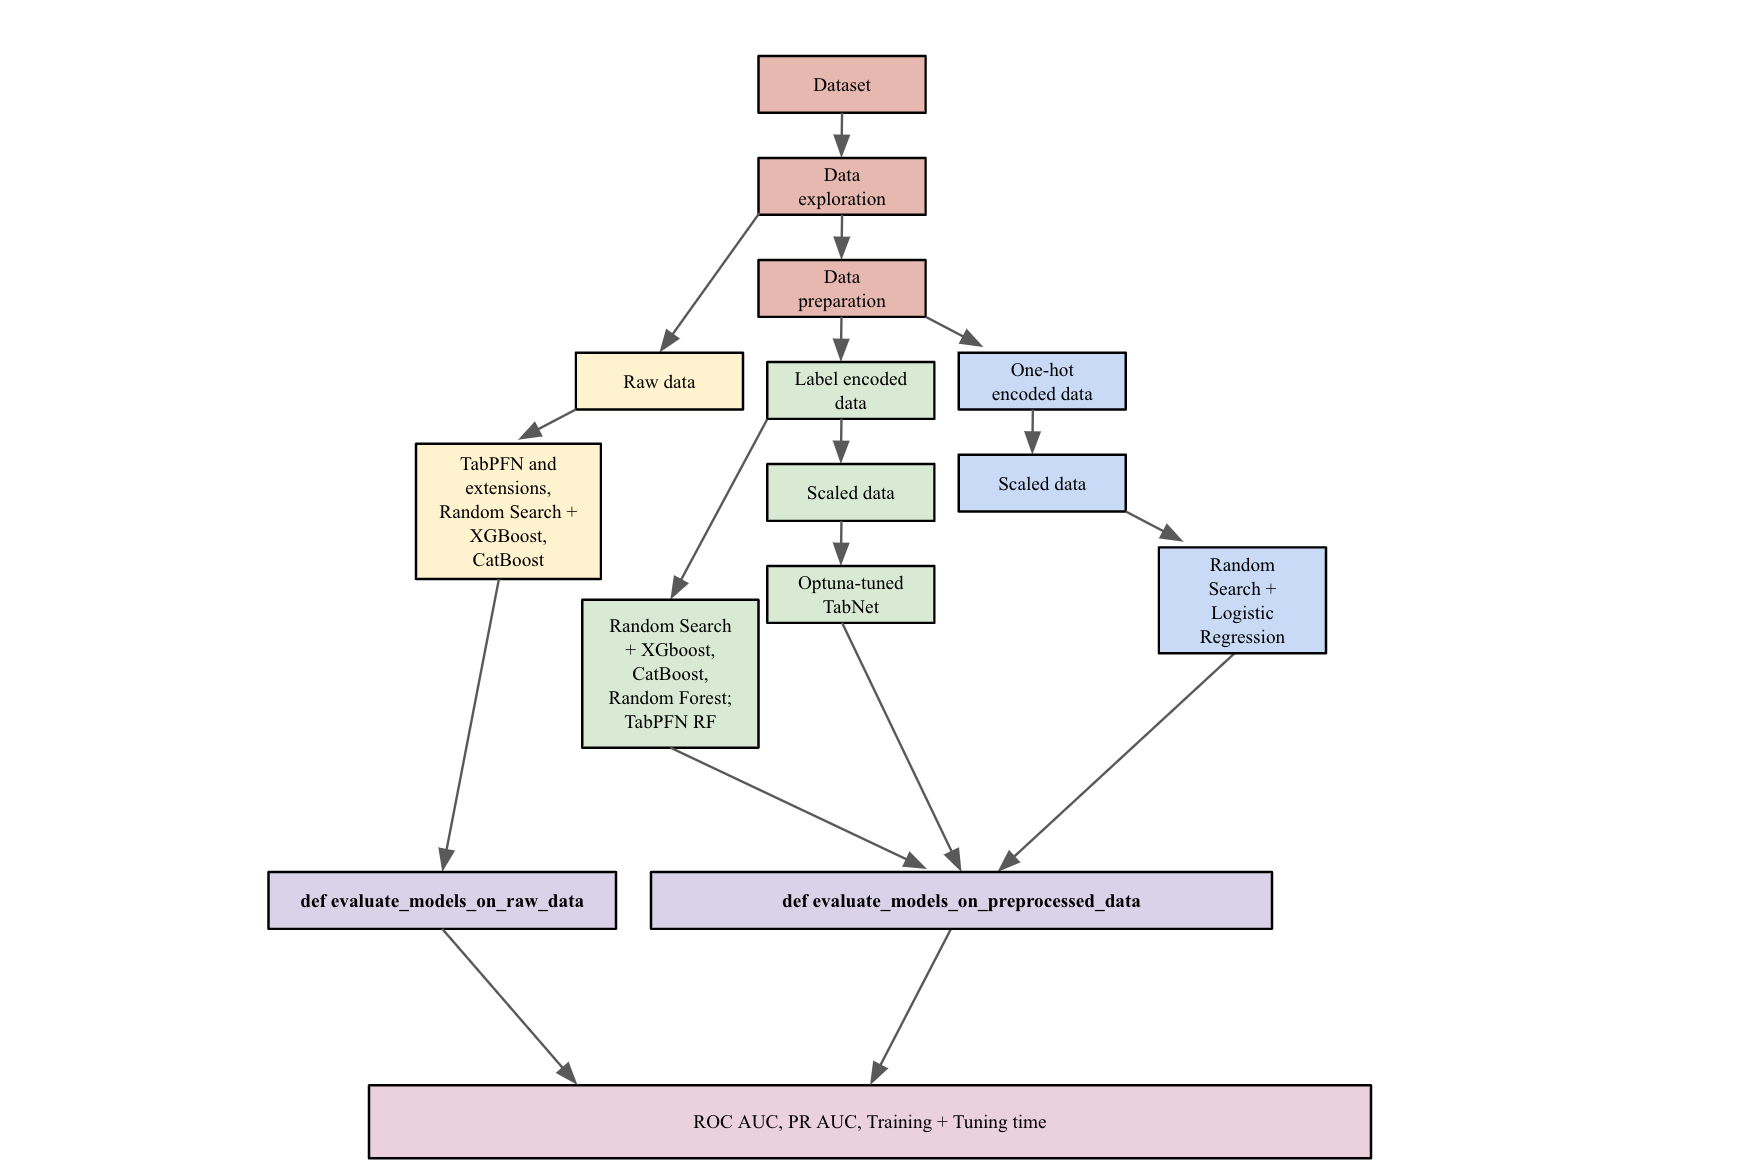

### **MODEL INITIALIZATION FUNCTIONS** ###

##### **TabPFN Model and its extensions:** #####

In [ ]:
# ----------------------------
# 1. Basic TabPFNClassifier:
# ----------------------------

def get_basic_tabpfn():
    """
    Initializes a basic TabPFNClassifier.

    Returns:
        TabPFNClassifier: A basic instance of the TabPFN classifier with fixed random state and parallelization.
    """
    return TabPFNClassifier(random_state=42, n_jobs=-1)

In [ ]:
# ----------------------------
# 2. AutoTabPFNClassifier:
# ----------------------------

def get_auto_tabpfn(categorical_feature_indices):
    """
    Initializes an AutoTabPFNClassifier with categorical feature support.

    Args:
        categorical_feature_indices (list of int): Indices of categorical features.

    Returns:
        AutoTabPFNClassifier: Configured AutoTabPFN model with categorical handling enabled.
    """
    return AutoTabPFNClassifier(
        random_state=42,
        preset="avoid_overfitting",
        device='cuda',
        categorical_feature_indices=categorical_feature_indices
    )


In [ ]:
# ----------------------------------------------------
# 3. Random Forest Preprocessing for TabPFNClassifier:
# ----------------------------------------------------

def get_rf_tabpfn(base_tabpfn_model):
    """
    Wraps a TabPFNClassifier in a RandomForestTabPFNClassifier for ensemble prediction.

    Parameters:
        base_tabpfn_model (TabPFNClassifier): An initialized TabPFN model.

    Returns:
        RandomForestTabPFNClassifier: Ensemble wrapper using Random Forest sampling.
    """
    return RandomForestTabPFNClassifier(
        tabpfn=TabPFNClassifier(random_state=42, n_jobs=-1),
        max_predict_time=60,
        random_state=42
    )

In [ ]:
# ----------------------------------------------
# 4. Subsampled Ensemble using TabPFNClassifier:
# ----------------------------------------------

def get_subsampled_tabpfn():
    """
    Initializes a TabPFNClassifier with subsampling.

    Returns:
        TabPFNClassifier: TabPFN model with customized inference configuration.
    """
    return TabPFNClassifier(
        random_state=42,
        inference_config={"SUBSAMPLE_SAMPLES": 2500}
    )

In [ ]:
# ----------------------------------------------------
# 5. Hyperparameter optimization for TabPFNClassifier:
# ----------------------------------------------------

def get_tuned_tabpfn(categorical_feature_indices):
    """
    Initializes a TunedTabPFNClassifier with categorical feature support.

    Args:
        categorical_feature_indices (list of int): Indices of categorical features.

    Returns:
        TunedTabPFNClassifier: Auto-tuning wrapper for TabPFN with categorical handling.
    """
    return TunedTabPFNClassifier(
        n_trials=30,
        random_state=42,
        verbose=0,
        categorical_feature_indices=categorical_feature_indices
    )


##### **Benchmark Models:** #####

In [ ]:
# ----------------------------
# 6. XGBClassifier:
# ----------------------------

def train_xgboost(X, y):
    """
    Trains an XGBoost classifier using randomized hyperparameter search.

    This function performs randomized search over a predefined hyperparameter space
    using 3-fold cross-validation, optimizing for ROC AUC.

    Args:
        X (pd.DataFrame or np.ndarray): Training features. Can include categorical features (XGBoost handles them natively if properly encoded).
        y (pd.Series or np.ndarray): Target labels for binary classification.

    Returns:
        XGBClassifier: Best XGBoost model fitted on the full training data with tuned hyperparameters.
    """
    # Initialize model with histogram-based tree growth and support for categorical features
    model = XGBClassifier(
        tree_method='hist',
        eval_metric='logloss',
        random_state=42,
        enable_categorical=True
    )

    # Define the hyperparameter space
    param_dist = {
        'n_estimators': randint(20, 200),
        'learning_rate': loguniform(np.exp(-7), 1),
        'max_depth': randint(1, 11),
        'subsample': uniform(0.2, 0.8),
        'reg_alpha': loguniform(np.exp(-16), np.exp(2)),
        'reg_lambda': loguniform(np.exp(-16), np.exp(2))
    }

    # Perform randomized search with 3-fold cross-validation
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Fit the search object and return the best model
    search.fit(X, y)
    return search.best_estimator_

In [ ]:
# ----------------------------
# 7. CatBoostClassifier:
# ----------------------------

def train_catboost(X, y, categorical_columns=None):
    """
    Trains a CatBoost classifier with randomized hyperparameter search.

    CatBoost natively supports categorical features, which can be passed using the column names.
    This function tunes key hyperparameters using RandomizedSearchCV with ROC AUC as the evaluation metric.

    Args:
        X (pd.DataFrame or np.ndarray): Training features.
        y (pd.Series or np.ndarray): Binary classification labels.
        categorical_columns (list of str or None): Names of categorical columns. If None, categorical handling is skipped.

    Returns:
        CatBoostClassifier: Best model found during randomized search, trained on full input data.
    """
    # Ensure cat_features are properly passed only if DataFrame and categories exist
    if isinstance(X, pd.DataFrame) and categorical_columns:
        model = CatBoostClassifier(
            cat_features=categorical_columns,
            random_state=42,
            verbose=0
        )
    else:
        model = CatBoostClassifier(random_state=42, verbose=0)

    param_dist = {
        'iterations': randint(20, 200),
        'learning_rate': loguniform(1e-5, 1),
        'depth': randint(2, 10),
        'l2_leaf_reg': loguniform(1, 10),
    }

    # Perform randomized search with 3-fold cross-validation
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X, y)
    return search.best_estimator_

In [ ]:
# ----------------------------
# 8. RandomForestClassifier:
# ----------------------------

def train_random_forest(X, y):
    """
    Trains a Random Forest classifier using randomized hyperparameter search.

    This function applies RandomizedSearchCV to tune important hyperparameters such as
    the number of trees, tree depth, and split criteria. Evaluation is based on ROC AUC.

    Args:
        X (pd.DataFrame or np.ndarray): Input feature matrix (encoded and numeric).
        y (pd.Series or np.ndarray): Binary classification labels.

    Returns:
        RandomForestClassifier: Best-performing model after hyperparameter tuning.
    """
    # Define base model
    model = RandomForestClassifier(random_state=42)

    # Define hyperparameter search space
    param_dist = {
        'n_estimators': randint(20, 200),
        'max_features': ['log2', 'sqrt'],
        'max_depth': randint(1, 46),
        'min_samples_split': [5, 10]
    }

    # Perform randomized search with 3-fold cross-validation
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Fit search and return the best model
    search.fit(X, y)
    return search.best_estimator_

In [ ]:
# ----------------------------
# 9. Logistic Regression:
# ----------------------------

def train_logistic_regression(X, y):
    """
    Trains a Logistic Regression classifier using randomized hyperparameter search.

    This function uses RandomizedSearchCV to tune regularization strength, penalty type,
    and maximum number of iterations. Evaluation is based on ROC AUC.

    Args:
        X (pd.DataFrame or np.ndarray): Scaled and encoded input features.
        y (pd.Series or np.ndarray): Binary classification labels.

    Returns:
        LogisticRegression: Best-performing logistic regression model after tuning.
    """
    # Initialize model with SAGA solver (supports both L1 and L2 penalties)
    model = LogisticRegression(random_state=42, solver='saga')

    # Define hyperparameter search space
    param_dist = {
        'C': loguniform(1e-4, 1e2),
        'penalty': ['l1', 'l2', None],
        'max_iter': randint(100, 1000)
    }

    # Perform randomized search with 3-fold cross-validation
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    # Fit the model and return the best estimator
    search.fit(X, y)
    return search.best_estimator_

In [ ]:
# ----------------------------------------------
# 10. Tuned TabNetClassifier: objective function
# ----------------------------------------------

def tabnet_objective(trial, X_train_part, X_val, y_train_part, y_val, cat_idxs=None, cat_dims=None, seed=42):
    """
    Objective function used by Optuna to optimize hyperparameters for TabNet.

    It trains a TabNet model with a sampled set of hyperparameters and returns the ROC AUC on the validation set.

    Args:
        trial (optuna.trial.Trial): Current optimization trial.
        X_train_part (np.ndarray): Partial training feature matrix.
        X_val (np.ndarray): Validation feature matrix.
        y_train_part (np.ndarray): Partial training target values.
        y_val (np.ndarray): Validation target values.
        cat_idxs (list[int], optional): Column indices of categorical features.
        cat_dims (list[int], optional): Number of unique values per categorical feature.
        seed (int): Random seed for reproducibility.

    Returns:
        float: ROC AUC score on the validation set (used as objective value).
    """

    # Sample hyperparameters using Optuna
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_a': trial.suggest_int('n_a', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 0.0, 1e-3),
        'n_independent': trial.suggest_int('n_independent', 1, 5),
        'n_shared': trial.suggest_int('n_shared', 1, 5),
        'momentum': trial.suggest_float('momentum', 0.01, 0.4),
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': {'lr': trial.suggest_float('lr', 1e-3, 1e-1, log=True)},
        'verbose': 0,
        'seed': seed,
        'cat_idxs': cat_idxs,
        'cat_dims': cat_dims
    }

    # Initialize TabNet with current hyperparameters
    model = TabNetClassifier(**params)

    # Train TabNet model with early stopping
    model.fit(
        X_train_part, y_train_part,
        eval_set=[(X_val, y_val)],
        eval_name=['val'],
        eval_metric=['auc'],
        max_epochs=50,
        patience=5,
        batch_size=512,
        virtual_batch_size=64,
        drop_last=False
    )

    # Evaluate performance using AUC on validation set
    val_preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_preds)
    return auc


In [ ]:
# -------------------------------------
# 10. Tuned TabNetClassifier: continued
# -------------------------------------

def train_tuned_tabnet(X_train_label_encoded_scaled, y_train, cat_idxs=None, cat_dims=None, n_trials=30, seed=42):
    """
    Tunes and trains a TabNetClassifier using Optuna and returns the best model.

    Args:
        X_train_label_encoded_scaled (pd.DataFrame): Scaled and label-encoded training features.
        y_train (pd.Series): Target labels.
        cat_idxs (list[int], optional): Indices of categorical features.
        cat_dims (list[int], optional): Number of unique values per categorical feature.
        n_trials (int): Number of Optuna trials for hyperparameter search.
        seed (int): Random seed for reproducibility.

    Returns:
        TabNetClassifier: The best model trained on the full training set.
    """
    # Set random seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Split training data for internal validation during tuning
    X_train_part, X_val, y_train_part, y_val = train_test_split(
        X_train_label_encoded_scaled, y_train, test_size=0.2, random_state=seed, stratify=y_train
    )

    # Convert to NumPy arrays (required by TabNet)
    X_train_part_np = X_train_part.to_numpy()
    X_val_np = X_val.to_numpy()
    y_train_part_np = y_train_part.to_numpy()
    y_val_np = y_val.to_numpy()

    # Set up and run Optuna hyperparameter optimization
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
    study.optimize(
        lambda trial: tabnet_objective(
            trial, X_train_part_np, X_val_np, y_train_part_np, y_val_np,
            cat_idxs=cat_idxs, cat_dims=cat_dims, seed=seed
        ),
        n_trials=n_trials
    )

    # Retrieve the best parameters from the study
    best_params = study.best_params

    # Initialize a new TabNet model with the best hyperparameters
    best_model = TabNetClassifier(
        n_d=best_params['n_d'],
        n_a=best_params['n_a'],
        n_steps=best_params['n_steps'],
        gamma=best_params['gamma'],
        lambda_sparse=best_params['lambda_sparse'],
        n_independent=best_params['n_independent'],
        n_shared=best_params['n_shared'],
        momentum=best_params['momentum'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr': best_params['lr']},
        verbose=0,
        seed=seed,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims
    )

    # Train the best model on the full dataset
    best_model.fit(
        X_train_label_encoded_scaled.to_numpy(), y_train.to_numpy(),
        eval_set=[(X_train_label_encoded_scaled.to_numpy(), y_train.to_numpy())],
        eval_name=['train'],
        eval_metric=['auc'],
        max_epochs=50,
        patience=5,
        batch_size=512,
        virtual_batch_size=64,
    )

    return best_model

### **EVALUATION FUNCTIONS** ###

In [ ]:
def evaluate_models_on_preprocessed_data(
    X_train_label_encoded, X_test_label_encoded,
    X_train_encoded_scaled, X_test_encoded_scaled,
    X_train_label_encoded_scaled, X_test_label_encoded_scaled,
    y_train, y_test,
    seed=42
):
    """
    Trains and evaluates multiple models on different preprocessed versions of the dataset.

    This function selects the appropriate input format for each model:
    - Tree-based models (e.g., Random Forest, XGBoost, CatBoost) use encoded or scaled data.
    - Models like TabNet use label-encoded and scaled data, with categorical metadata.
    - TabPFN is used inside an ensemble (TabPFN RF) with encoded data.

    Args:
        X_train_label_encoded: Label encoded training features (for tree-based models).
        X_test_label_encoded: Label encoded test features (for tree-based models).
        X_train_encoded_scaled: Encoded + scaled training features (for logit).
        X_test_encoded_scaled: Encoded + scaled test features (for logit).
        X_train_label_encoded_scaled: Label encoded + scaled training features (for TabNet).
        X_test_label_encoded_scaled: Label encoded + scaled test features (for TabNet).
        y_train: Training labels.
        y_test: Test labels.
        seed: Random seed for reproducibility.

    Returns:
        metrics: Dict with model names and their ROC AUC and PR AUC scores.
        training_times: Dict with training duration for each model.
        model_probas: Dict with model names and predicted probabilities.
    """

    # Prepare categorical metadata for TabNet
    # Prepare categorical metadata for TabNet using union of train/test categories
    cat_idxs = [int(i[0]) if isinstance(i, tuple) else int(i) for i in categorical_feature_indices]

    cat_dims = []
    for idx in cat_idxs:
        unique_train = X_train_label_encoded_scaled.iloc[:, idx].unique()
        unique_test = X_test_label_encoded_scaled.iloc[:, idx].unique()
        unique_combined = np.unique(np.concatenate([unique_train, unique_test]))
        cat_dims.append(len(unique_combined))


    # Define models and their corresponding training functions
    models_class = [
        ('TabPFN RF', lambda: get_rf_tabpfn(get_basic_tabpfn())),
        ('XGBoost preprocessed', lambda: train_xgboost(X_train_label_encoded, y_train)),
        ('CatBoost preprocessed', lambda: train_catboost(X_train_label_encoded, y_train, categorical_columns=None)),
        ('Random Forest', lambda: train_random_forest(X_train_label_encoded, y_train)),
        ('Logistic Regression', lambda: train_logistic_regression(X_train_encoded_scaled, y_train)),
        ('TabNet', lambda: train_tuned_tabnet(X_train_label_encoded_scaled, y_train, cat_idxs=cat_idxs, cat_dims=cat_dims))
    ]

    # Initialize output containers
    metrics = {}
    training_times = {}
    model_probas = {}

    # Train and evaluate each model
    for name, model_fn in models_class:
        print(f"\nTraining and evaluating {name}...")

        np.random.seed(seed)
        torch.manual_seed(seed)

        # Select appropriate input data based on the model type
        if name == "TabNet":
            X_train_input = X_train_label_encoded_scaled.to_numpy()
            X_test_input = X_test_label_encoded_scaled.to_numpy()
        elif name in ["Random Forest", "XGBoost preprocessed", "CatBoost preprocessed", "TabPFN RF"]:
            X_train_input = X_train_label_encoded
            X_test_input = X_test_label_encoded
        else:
            X_train_input = X_train_encoded_scaled
            X_test_input = X_test_encoded_scaled

        y_train_input = y_train

        # Train model and record training time
        start_time = time.time()
        model = model_fn()
        model.fit(X_train_input, y_train_input)
        end_time = time.time()

        training_times[name] = end_time - start_time

        # Ensure deterministic inference for PyTorch-based models
        if hasattr(model, 'eval'):
            model.eval()

        # Predict probabilities and evaluate performance
        y_proba = model.predict_proba(X_test_input)[:, 1]
        model_probas[name] = y_proba

        # Metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        metrics[name] = {
            "ROC AUC": roc_auc,
            "PR AUC": pr_auc
        }

        print(f"{name} Test ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f} | Time: {training_times[name]:.2f} sec")

    return metrics, training_times, model_probas

In [ ]:
def evaluate_models_on_raw_data(
    X_train_raw, X_test_raw,
    y_train, y_test,
    categorical_feature_indices,
    categorical_columns,
    seed=42
):
    """
    Trains and evaluates models that can operate directly on raw (unencoded, unscaled) data.

    This function is designed for models that natively support categorical features or
    are robust to unprocessed input, such as TabPFN, CatBoost, and XGBoost.

    Args:
        X_train_raw: Raw training features (categorical values retained).
        X_test_raw: Raw test features.
        y_train: Labels for training set.
        y_test: Labels for test set.
        categorical_feature_indices: List of categorical column indices (used in TabPFN).
        categorical_columns: List of categorical column names (used in CatBoost).
        seed: Random seed for reproducibility.

    Returns:
        metrics: Dictionary of ROC AUC scores per model.
        training_times: Dictionary of training durations per model.
        model_probas: Dict with model names and predicted probabilities.
    """

    # Define models and their corresponding training functions
    models_class = [
        ('TabPFN', get_basic_tabpfn),
        ('AutoTabPFN', lambda: get_auto_tabpfn(categorical_feature_indices)),
        ('TabPFN Subsample', get_subsampled_tabpfn),
        ('Tuned TabPFN', lambda: get_tuned_tabpfn(categorical_feature_indices)),
        ('XGBoost raw', lambda: train_xgboost(X_train_raw, y_train)),
        ('CatBoost raw', lambda: train_catboost(X_train_raw, y_train, categorical_columns)),
    ]

    # Initialize output containers
    metrics = {}
    training_times = {}
    model_probas = {}

    for name, model_fn in models_class:
        print(f"\nTraining and evaluating {name}...")

        # Set seeds for reproducibility
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Train model and record training time
        start_time = time.time()
        model = model_fn()
        model.fit(X_train_raw, y_train)
        end_time = time.time()

        training_times[name] = end_time - start_time

        # Predict probabilities and evaluate performance
        y_proba = model.predict_proba(X_test_raw)[:, 1]
        model_probas[name] = y_proba

        # Metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)

        metrics[name] = {
            "ROC AUC": roc_auc,
            "PR AUC": pr_auc
        }

        print(f"{name} Test ROC AUC: {roc_auc:.4f} | PR AUC: {pr_auc:.4f} | Time: {training_times[name]:.2f} sec")

    return metrics, training_times, model_probas

### **PLOTTING FUNCTIONS** ###

In [ ]:
def plot_roc_auc(all_metrics, dataset_name):
    """
    Plots a bar chart of ROC AUC scores for all evaluated models.

    Args:
        all_metrics (dict): Dictionary mapping model names to {'ROC AUC': ..., 'PR AUC': ...}.
        dataset_name (str): Name of the dataset (used in plot title).

    Returns:
        ax (matplotlib.axes.Axes): The Axes object of the generated plot.
    """

    df_auc = pd.DataFrame({
        'Model': list(all_metrics.keys()),
        'Test ROC AUC': [metrics['ROC AUC'] for metrics in all_metrics.values()]
    })

    df_auc = df_auc.sort_values(by='Test ROC AUC', ascending=False)

    ax = df_auc.plot(
        x='Model',
        y='Test ROC AUC',
        kind='bar',
        figsize=(12, 6),
        legend=False,
        color='skyblue',
        edgecolor='black'
    )

    ax.set_ylim(df_auc['Test ROC AUC'].min() * 0.995,
                min(1.0, df_auc['Test ROC AUC'].max() * 1.005))

    ax.set_ylabel("ROC AUC")
    ax.set_title(f"ROC AUC Scores of {dataset_name}")
    ax.set_xticklabels(df_auc['Model'], rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    return ax

In [ ]:
def plot_precision_recall_curves(model_probas, y_test):
    """
    Plots precision-recall curves for all models and adds a baseline (churn rate).

    Args:
        model_probas (dict): Dictionary mapping model names to predicted probabilities.
        y_test (array-like): True binary labels (0 or 1).
    """

    # Calculate baseline = churn rate
    churn_rate = sum(y_test) / len(y_test)

    plt.figure(figsize=(10, 6))

    # Generate and plot PR curve for each model
    for name, y_proba in model_probas.items():
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name} (AP = {pr_auc:.4f})")

    # Add baseline horizontal line at churn rate level
    plt.hlines(y=churn_rate, xmin=0, xmax=1, colors='gray', linestyles='dashed', label=f'Baseline (Churn Rate = {churn_rate:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc='lower left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

### **BEGINNING OF EMPIRICAL PART** ###

### **DATASET 1** ###

In [ ]:
# Upload the first dataset
uploaded = files.upload()

pd.set_option('display.max_columns', None)
ibm_data = pd.read_csv('Telco-Customer-Churn.csv')
ibm_data.head()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (2).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### **Data exploration and preparation** ###

##### **Exploration** #####

In [ ]:
# Rename columns: insert underscore before uppercase letters and convert all to lowercase
df_ibm = ibm_data.copy()

df_ibm.columns = (df_ibm.columns \
    .str.replace(r'(?<=[a-z])(?=[A-Z])', '_', regex=True)
    .str.lower()
)

In [ ]:
# Check data types and missing values in the dataset
df_ibm.info()
# Observation:
# Some columns like 'total_charges' and 'churn' are of type 'object' and need to be converted to numerical types
# No missing values are reported

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperless_billing  7043 

In [ ]:
# Check unique values in each column to detect inconsistencies, unexpected categorical levels, potential problems like typos
for col in df_ibm.columns:
    print(f"Column: {col}")
    print(np.sort(df_ibm[col].unique()))
    print("-" * 40)

Column: customer_id
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
----------------------------------------
Column: gender
['Female' 'Male']
----------------------------------------
Column: senior_citizen
[0 1]
----------------------------------------
Column: partner
['No' 'Yes']
----------------------------------------
Column: dependents
['No' 'Yes']
----------------------------------------
Column: tenure
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
----------------------------------------
Column: phone_service
['No' 'Yes']
----------------------------------------
Column: multiple_lines
['No' 'No phone service' 'Yes']
----------------------------------------
Column: internet_service
['DSL' 'Fiber optic' 'No']
----------------------------------------
Column: online_securit

In [ ]:
# Check duplicates in the dataset
df_ibm.duplicated().sum()
# No duplicates

np.int64(0)

In [ ]:
# The 'customer_id' column is just an identifier and not useful for analysis or modeling, so we remove it
df_ibm.drop('customer_id', axis=1, inplace=True)

In [ ]:
# Convert variables to appropriate data types to facilitate later analysis and feature selection

# 1. Convert 'total_charges' from object to numeric, coerce invalid entries to NaN
df_ibm['total_charges'] = pd.to_numeric(df_ibm['total_charges'], errors='coerce')

# Replace NaN values in 'total_charges' with 0
df_ibm['total_charges'] = df_ibm['total_charges'].fillna(0)

# 2. Convert 'senior_citizen' from numeric to categorical
df_ibm['senior_citizen'] = df_ibm['senior_citizen'].astype('category')

# 3. Convert target variable 'churn' to binary integer format: 1 for 'Yes', 0 for 'No'
df_ibm['churn'] = df_ibm['churn'].replace({'Yes': 1, 'No': 0}).astype(int)

# 4. Convert all remaining object-type columns to categorical (needed for models that handle categorical features)
object_cols = df_ibm.select_dtypes(include='object').columns
df_ibm[object_cols] = df_ibm[object_cols].astype('category')

In [ ]:
# 1. Identify categorical and numerical features
categorical_columns = df_ibm.select_dtypes(include='category').columns.tolist()
numerical_features = df_ibm.select_dtypes(include=['float64', 'int64']).drop(columns='churn').columns.tolist()  # exclude target

# 2. Get column indices of categorical features (needed for TabNet embeddings)
categorical_feature_indices = [df_ibm.columns.get_loc(col) for col in categorical_columns]

In [ ]:
df_ibm.describe()
# The target variable 'churn' appears to be imbalanced
# Numerical variables are on very different scales, which may require scaling before modeling

,tenure,monthly_charges,total_charges,churn
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,0.265370
std,24.559481,30.090047,2266.794470,0.441561
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.500000,398.550000,0.000000
50%,29.000000,70.350000,1394.550000,0.000000
75%,55.000000,89.850000,3786.600000,1.000000
max,72.000000,118.750000,8684.800000,1.000000


##### **Preparation of the raw data (for TabPFN and extensions, XGBoost, CatBoost)** #####

In [ ]:
# Save a copy of the raw data for use in models that accept categorical features directly
df_raw = df_ibm.copy()
df_raw = df_ibm.copy()
df_raw

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


In [ ]:
# Separate features and target variable
X = df_raw.drop(columns=['churn'])
y = df_raw['churn']

# Split the data into training and testing sets (80% train, 20% test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### **Preparation of label encoded (for tree-based models) and scaled data (for TabNet model)** #####

In [ ]:
# Create a copy of the preprocessed DataFrame for label encoding
df_label_encoded = df_ibm.copy()

# Apply Label Encoding to all categorical columns
le = LabelEncoder()
for col in categorical_columns:
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])

df_label_encoded

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


In [ ]:
X = df_label_encoded.drop(columns=['churn'])
y = df_label_encoded['churn']

X_train_label_encoded, X_test_label_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Rescale numerical features in the label-encoded data using StandardScaler
X_train_label_encoded_scaled = X_train_label_encoded.copy()
X_test_label_encoded_scaled = X_test_label_encoded.copy()

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_train_label_encoded_scaled[numerical_features] = scaler.fit_transform(X_train_label_encoded_scaled[numerical_features])
X_test_label_encoded_scaled[numerical_features] = scaler.transform(X_test_label_encoded_scaled[numerical_features])

##### **Preparation of the One-Hot-encoded and scaled data (for Logistic Regression)** #####

In [ ]:
# Make a copy of the label-encoded DataFrame to apply one-hot encoding
df_encoded = df_label_encoded.copy()

# Apply one-hot encoding to all categorical columns and drop the first level
df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns, drop_first=True)

# Convert True/False columns to 1/0
df_encoded = df_encoded.replace({True: 1, False: 0})

df_encoded

,tenure,monthly_charges,total_charges,churn,gender_1,senior_citizen_1,partner_1,dependents_1,phone_service_1,multiple_lines_1,multiple_lines_2,internet_service_1,internet_service_2,online_security_1,online_security_2,online_backup_1,online_backup_2,device_protection_1,device_protection_2,tech_support_1,tech_support_2,streaming_tv_1,streaming_tv_2,streaming_movies_1,streaming_movies_2,contract_1,contract_2,paperless_billing_1,payment_method_1,payment_method_2,payment_method_3
0,1,29.85,29.85,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,0,1,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1
7039,72,103.20,7362.90,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0
7040,11,29.60,346.45,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
7041,4,74.40,306.60,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
X = df_encoded.drop(columns=['churn'])
y = df_encoded['churn']

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_encoded_scaled = X_train_encoded.copy()
X_test_encoded_scaled = X_test_encoded.copy()

scaler = StandardScaler()
X_train_encoded_scaled[numerical_features] = scaler.fit_transform(X_train_encoded_scaled[numerical_features])
X_test_encoded_scaled[numerical_features] = scaler.transform(X_test_encoded_scaled[numerical_features])

### **Modelling of results** ###

In [ ]:
# Evaluate all models using preprocessed data (encoded, scaled, or label-encoded)
metrics_preprocessed_dataset_1, training_times_preprocessed_dataset_1, model_probas_preprocessed_dataset_1 = evaluate_models_on_preprocessed_data(
    X_train_label_encoded, X_test_label_encoded,
    X_train_encoded_scaled, X_test_encoded_scaled,
    X_train_label_encoded_scaled, X_test_label_encoded_scaled,
    y_train, y_test
)


Training and evaluating TabPFN RF...
TabPFN RF Test ROC AUC: 0.8514 | PR AUC: 0.6817 | Time: 0.75 sec

Training and evaluating XGBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost preprocessed Test ROC AUC: 0.8625 | PR AUC: 0.6947 | Time: 1.63 sec

Training and evaluating CatBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost preprocessed Test ROC AUC: 0.8637 | PR AUC: 0.6982 | Time: 10.77 sec

Training and evaluating Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest Test ROC AUC: 0.8619 | PR AUC: 0.6985 | Time: 5.29 sec

Training and evaluating Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[I 2025-06-15 22:42:06,737] A new study created in memory with name: no-name-d0332026-9b2a-4976-b859-5a9650508740


Logistic Regression Test ROC AUC: 0.8618 | PR AUC: 0.6807 | Time: 7.06 sec

Training and evaluating TabNet...

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.78538


[I 2025-06-15 22:42:17,748] Trial 0 finished with value: 0.7853836459696574 and parameters: {'n_d': 29, 'n_a': 62, 'n_steps': 8, 'gamma': 1.5986584841970366, 'lambda_sparse': 0.00015601864044243653, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.34780869685222476, 'lr': 0.015930522616241012}. Best is trial 0 with value: 0.7853836459696574.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.7856


[I 2025-06-15 22:42:33,589] Trial 1 finished with value: 0.7855977251062318 and parameters: {'n_d': 48, 'n_a': 9, 'n_steps': 10, 'gamma': 1.8324426408004217, 'lambda_sparse': 0.00021233911067827617, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.1286544747542197, 'lr': 0.01120760621186057}. Best is trial 1 with value: 0.7855977251062318.



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.81941


[I 2025-06-15 22:43:05,788] Trial 2 finished with value: 0.8194060717690207 and parameters: {'n_d': 32, 'n_a': 24, 'n_steps': 7, 'gamma': 1.139493860652042, 'lambda_sparse': 0.00029214464853521814, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.31621862494327535, 'lr': 0.002508115686045232}. Best is trial 2 with value: 0.8194060717690207.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.79921


[I 2025-06-15 22:43:11,945] Trial 3 finished with value: 0.7992139660381626 and parameters: {'n_d': 37, 'n_a': 41, 'n_steps': 3, 'gamma': 1.6075448519014384, 'lambda_sparse': 0.00017052412368729152, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.38659649289907816, 'lr': 0.041380401125610165}. Best is trial 2 with value: 0.8194060717690207.



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.80285


[I 2025-06-15 22:43:39,775] Trial 4 finished with value: 0.8028452329019437 and parameters: {'n_d': 25, 'n_a': 13, 'n_steps': 8, 'gamma': 1.4401524937396013, 'lambda_sparse': 0.00012203823484477882, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36463495681072505, 'lr': 0.0032927591344236173}. Best is trial 2 with value: 0.8194060717690207.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.75659


[I 2025-06-15 22:44:04,900] Trial 5 finished with value: 0.7565900021003992 and parameters: {'n_d': 45, 'n_a': 25, 'n_steps': 7, 'gamma': 1.5467102793432796, 'lambda_sparse': 0.00018485445552552705, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.3764045872100338, 'lr': 0.06161049539380966}. Best is trial 2 with value: 0.8194060717690207.



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.84184


[I 2025-06-15 22:44:15,723] Trial 6 finished with value: 0.8418359103614304 and parameters: {'n_d': 42, 'n_a': 60, 'n_steps': 3, 'gamma': 1.1959828624191453, 'lambda_sparse': 4.5227288910538064e-05, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.1158261223918194, 'lr': 0.045443839603360174}. Best is trial 6 with value: 0.8418359103614304.



Early stopping occurred at epoch 41 with best_epoch = 36 and best_val_auc = 0.81496


[I 2025-06-15 22:45:08,763] Trial 7 finished with value: 0.8149568610343657 and parameters: {'n_d': 28, 'n_a': 24, 'n_steps': 7, 'gamma': 1.1409242249747626, 'lambda_sparse': 0.0008021969807540396, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.3111754600256964, 'lr': 0.002497073714505273}. Best is trial 6 with value: 0.8418359103614304.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.8111


[I 2025-06-15 22:45:16,303] Trial 8 finished with value: 0.8110953581180425 and parameters: {'n_d': 8, 'n_a': 54, 'n_steps': 8, 'gamma': 1.7290071680409873, 'lambda_sparse': 0.0007712703466859458, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.05518893321480059, 'lr': 0.05323617594751501}. Best is trial 6 with value: 0.8418359103614304.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.83646


[I 2025-06-15 22:45:28,764] Trial 9 finished with value: 0.8364556573441262 and parameters: {'n_d': 43, 'n_a': 26, 'n_steps': 3, 'gamma': 1.3109823217156622, 'lambda_sparse': 0.00032518332202674706, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.35601296960476736, 'lr': 0.008798929749689027}. Best is trial 6 with value: 0.8418359103614304.



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_auc = 0.84334


[I 2025-06-15 22:45:50,988] Trial 10 finished with value: 0.843340523160939 and parameters: {'n_d': 62, 'n_a': 47, 'n_steps': 5, 'gamma': 1.0179618756148194, 'lambda_sparse': 0.0005656130906814032, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16305662792002662, 'lr': 0.02176951803542743}. Best is trial 10 with value: 0.843340523160939.



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.85012


[I 2025-06-15 22:46:08,068] Trial 11 finished with value: 0.8501163297949688 and parameters: {'n_d': 64, 'n_a': 48, 'n_steps': 5, 'gamma': 1.0264334689008265, 'lambda_sparse': 0.000555502018035624, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.1941337015517955, 'lr': 0.025897641777143522}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.81885


[I 2025-06-15 22:46:23,968] Trial 12 finished with value: 0.818848658168129 and parameters: {'n_d': 63, 'n_a': 44, 'n_steps': 5, 'gamma': 1.012695273016709, 'lambda_sparse': 0.0005639593321731279, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.23186488457156973, 'lr': 0.02176902952454701}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.80061


[I 2025-06-15 22:46:34,149] Trial 13 finished with value: 0.8006075000403923 and parameters: {'n_d': 64, 'n_a': 45, 'n_steps': 5, 'gamma': 1.003438719853647, 'lambda_sparse': 0.0005711093668691417, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.20819513793507, 'lr': 0.006025115052042798}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_auc = 0.79739


[I 2025-06-15 22:46:58,886] Trial 14 finished with value: 0.7973902541482882 and parameters: {'n_d': 54, 'n_a': 51, 'n_steps': 5, 'gamma': 1.9960169893612132, 'lambda_sparse': 0.000995304115575582, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.1601374822177307, 'lr': 0.025695327964024472}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_auc = 0.81631


[I 2025-06-15 22:47:22,545] Trial 15 finished with value: 0.8162352770103243 and parameters: {'n_d': 56, 'n_a': 36, 'n_steps': 4, 'gamma': 1.2977131515194196, 'lambda_sparse': 0.0004443418119751308, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.2554435238429047, 'lr': 0.09006020499939703}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 35 with best_epoch = 30 and best_val_auc = 0.79124


[I 2025-06-15 22:47:54,416] Trial 16 finished with value: 0.791236488779022 and parameters: {'n_d': 57, 'n_a': 35, 'n_steps': 6, 'gamma': 1.3493152496086436, 'lambda_sparse': 0.0006910722043756795, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.020615420292566744, 'lr': 0.001062572149732749}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.84224


[I 2025-06-15 22:48:12,899] Trial 17 finished with value: 0.8422438724896192 and parameters: {'n_d': 20, 'n_a': 52, 'n_steps': 4, 'gamma': 1.0958918433421065, 'lambda_sparse': 0.00044773059681261894, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.18246889662228702, 'lr': 0.027916892642289085}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.83377


[I 2025-06-15 22:48:38,286] Trial 18 finished with value: 0.833773609293458 and parameters: {'n_d': 51, 'n_a': 56, 'n_steps': 6, 'gamma': 1.2310267208681167, 'lambda_sparse': 0.0006559579723273912, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.08991803163278714, 'lr': 0.015430311034200384}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.77316


[I 2025-06-15 22:48:43,260] Trial 19 finished with value: 0.773160939039956 and parameters: {'n_d': 60, 'n_a': 48, 'n_steps': 4, 'gamma': 1.4318577859996768, 'lambda_sparse': 0.0009232702099147684, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.26501474554093374, 'lr': 0.006060839867198844}. Best is trial 11 with value: 0.8501163297949688.



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.85099


[I 2025-06-15 22:49:27,701] Trial 20 finished with value: 0.8509867836427383 and parameters: {'n_d': 51, 'n_a': 32, 'n_steps': 10, 'gamma': 1.0795446705747698, 'lambda_sparse': 0.0003678802070805611, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.1513726208354365, 'lr': 0.097204320811372}. Best is trial 20 with value: 0.8509867836427383.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.85154


[I 2025-06-15 22:49:57,084] Trial 21 finished with value: 0.8515441972436302 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 10, 'gamma': 1.0631595441762953, 'lambda_sparse': 0.0003638744895779687, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.1588432705231473, 'lr': 0.08876156342036481}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.84076


[I 2025-06-15 22:50:19,141] Trial 22 finished with value: 0.8407574362205742 and parameters: {'n_d': 52, 'n_a': 31, 'n_steps': 10, 'gamma': 1.1048038593255378, 'lambda_sparse': 0.0003588892695932592, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.11431500754603999, 'lr': 0.08724882959588341}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 37 with best_epoch = 32 and best_val_auc = 0.84484


[I 2025-06-15 22:51:18,969] Trial 23 finished with value: 0.844835037887968 and parameters: {'n_d': 58, 'n_a': 17, 'n_steps': 9, 'gamma': 1.2047597231830094, 'lambda_sparse': 0.0004103969867133103, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.20188218873939198, 'lr': 0.07029340943753487}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.83334


[I 2025-06-15 22:51:40,250] Trial 24 finished with value: 0.8333353529478293 and parameters: {'n_d': 49, 'n_a': 40, 'n_steps': 9, 'gamma': 1.1035336125638389, 'lambda_sparse': 0.00048462321822815153, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.1481722669415865, 'lr': 0.03469426664712112}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.83333


[I 2025-06-15 22:51:54,963] Trial 25 finished with value: 0.8333252548753494 and parameters: {'n_d': 64, 'n_a': 30, 'n_steps': 9, 'gamma': 1.0568130615962126, 'lambda_sparse': 0.0002677456456896361, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.07812259777010469, 'lr': 0.09741433624106142}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.83634


[I 2025-06-15 22:52:23,089] Trial 26 finished with value: 0.8363405393178551 and parameters: {'n_d': 58, 'n_a': 19, 'n_steps': 10, 'gamma': 1.2519042591500669, 'lambda_sparse': 0.0003657621926608246, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.22254925053861413, 'lr': 0.06064458256625141}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.843


[I 2025-06-15 22:52:55,517] Trial 27 finished with value: 0.8429951690821256 and parameters: {'n_d': 39, 'n_a': 37, 'n_steps': 9, 'gamma': 1.169730479176351, 'lambda_sparse': 0.0006433358358431812, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.18525364119203616, 'lr': 0.03560207784029274}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_auc = 0.83513


[I 2025-06-15 22:53:38,191] Trial 28 finished with value: 0.8351166529332881 and parameters: {'n_d': 54, 'n_a': 30, 'n_steps': 10, 'gamma': 1.3771418287643094, 'lambda_sparse': 0.0005079569525248348, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.25489646473390865, 'lr': 0.06765179240441224}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.83141


[I 2025-06-15 22:53:55,717] Trial 29 finished with value: 0.8314146995621476 and parameters: {'n_d': 48, 'n_a': 63, 'n_steps': 8, 'gamma': 1.0719889305010697, 'lambda_sparse': 0.00025447060586548546, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.14493866582106707, 'lr': 0.015866543601256406}. Best is trial 21 with value: 0.8515441972436302.



Early stopping occurred at epoch 37 with best_epoch = 32 and best_train_auc = 0.8407
TabNet Test ROC AUC: 0.8526 | PR AUC: 0.6725 | Time: 876.53 sec


In [ ]:
# Evaluate all models that support raw input data
metrics_raw_dataset_1, training_times_raw_dataset_1, model_probas_raw_dataset_1 = evaluate_models_on_raw_data(
    X_train_raw, X_test_raw,
    y_train, y_test,
    categorical_feature_indices,
    categorical_columns
)


Training and evaluating TabPFN...
TabPFN Test ROC AUC: 0.8649 | PR AUC: 0.6996 | Time: 0.30 sec

Training and evaluating AutoTabPFN...


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(-0.8476826717549361), np.float64(-0.8477038333897644), np.float64(-0.8477442181890552), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float64(-0.847765864441475), np.float6

AutoTabPFN Test ROC AUC: 0.8648 | PR AUC: 0.6992 | Time: 33.64 sec

Training and evaluating TabPFN Subsample...
TabPFN Subsample Test ROC AUC: 0.8642 | PR AUC: 0.6958 | Time: 0.23 sec

Training and evaluating Tuned TabPFN...
Tuned TabPFN Test ROC AUC: 0.8663 | PR AUC: 0.6997 | Time: 42.93 sec

Training and evaluating XGBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost raw Test ROC AUC: 0.8650 | PR AUC: 0.7017 | Time: 4.51 sec

Training and evaluating CatBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost raw Test ROC AUC: 0.8649 | PR AUC: 0.6994 | Time: 28.38 sec


### **Plotting the results** ###

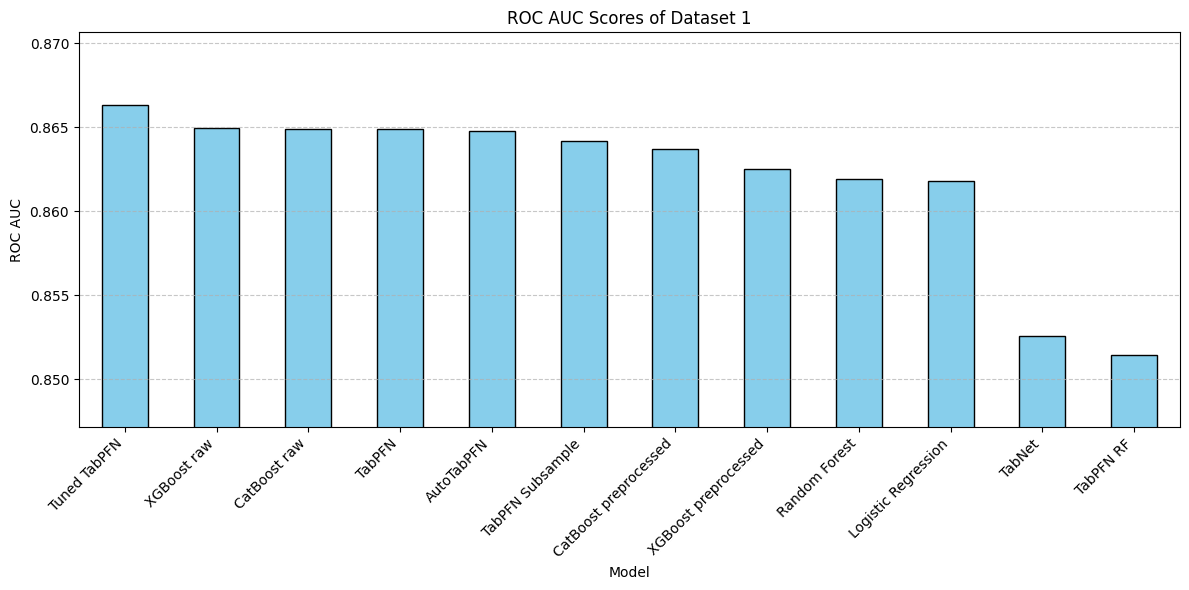

<Axes: title={'center': 'ROC AUC Scores of Dataset 1'}, xlabel='Model', ylabel='ROC AUC'>

In [ ]:
# Combine metrics from both preprocessed and raw models into a single dictionary
all_metrics_dataset_1 = {
    **metrics_preprocessed_dataset_1,
    **metrics_raw_dataset_1
}

# Plot ROC AUC scores for all models on Dataset 1
plot_roc_auc(all_metrics_dataset_1, dataset_name="Dataset 1")

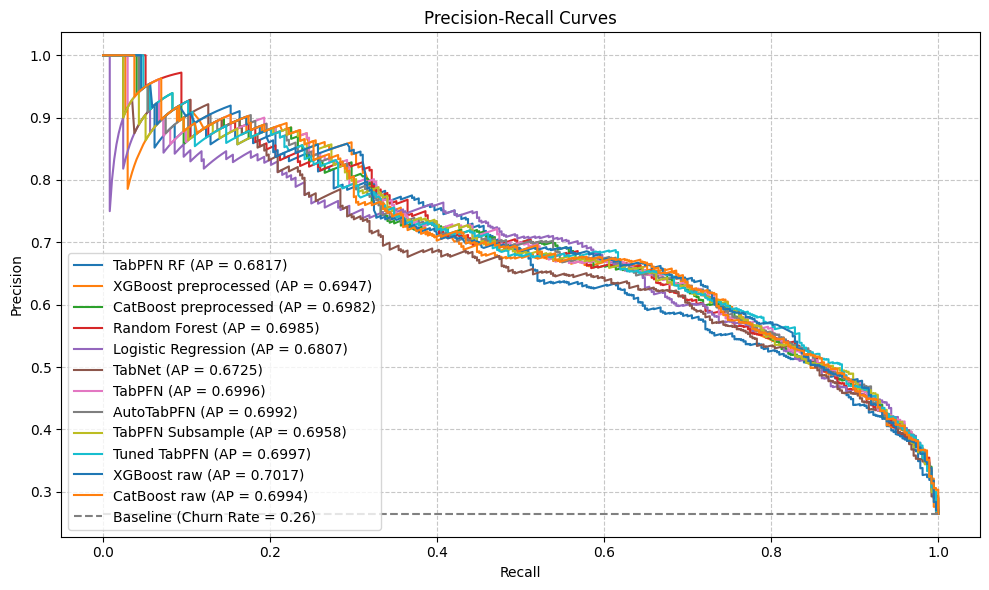

In [ ]:
# Combine predicted probabilities from all models (preprocessed and raw)
all_model_probas_dataset_1 = {
    **model_probas_preprocessed_dataset_1,
    **model_probas_raw_dataset_1
}

# Plot precision-recall curves for all models and add churn rate as baseline
plot_precision_recall_curves(all_model_probas_dataset_1, y_test)

###**DATASET 2**###

In [ ]:
# Upload the second dataset
uploaded = files.upload()

pd.set_option('display.max_columns', None)
uci_data = pd.read_csv('Customer_Churn.csv')
uci_data.head()

Saving Customer_Churn.csv to Customer_Churn (1).csv


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


### **Data exploration and preparation** ###

##### **Exploration** #####

In [ ]:
# Rename columns: insert underscore before uppercase letters and convert all to lowercase
df_uci = uci_data.copy()

df_uci.columns = (df_uci.columns \
    .str.replace('  ', '_')
    .str.lower()
    .str.replace(' ', '_')
)

In [ ]:
df_uci.info()
# No missing values are reported
# All features have numerical values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_failure             3150 non-null   int64  
 1   complains                3150 non-null   int64  
 2   subscription_length      3150 non-null   int64  
 3   charge_amount            3150 non-null   int64  
 4   seconds_of_use           3150 non-null   int64  
 5   frequency_of_use         3150 non-null   int64  
 6   frequency_of_sms         3150 non-null   int64  
 7   distinct_called_numbers  3150 non-null   int64  
 8   age_group                3150 non-null   int64  
 9   tariff_plan              3150 non-null   int64  
 10  status                   3150 non-null   int64  
 11  age                      3150 non-null   int64  
 12  customer_value           3150 non-null   float64
 13  churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [ ]:
# Check unique values in each column to detect inconsistencies, unexpected categorical levels, potential problems like typos
for col in df_uci.columns:
    print(f"Column: {col}")
    print(np.sort(df_uci[col].unique()))
    print("-" * 40)

Column: call_failure
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
----------------------------------------
Column: complains
[0 1]
----------------------------------------
Column: subscription_length
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
----------------------------------------
Column: charge_amount
[ 0  1  2  3  4  5  6  7  8  9 10]
----------------------------------------
Column: seconds_of_use
[    0     8    13 ... 16785 16980 17090]
----------------------------------------
Column: frequency_of_use
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  7

In [ ]:
# Check duplicates in the dataset
df_uci.duplicated().sum()

np.int64(300)

In [ ]:
# Drop 300 duplicate rows from the dataset
df_uci.drop_duplicates(inplace=True)

In [ ]:
# Drop 'age' column from the dataset because it's categorical and duplicates the meaning of 'age_group'
df_uci = df_uci.drop(columns=['age'], errors='ignore')

In [ ]:
# List of columns to convert to categorical
columns_to_convert = ['complains', 'charge_amount', 'age_group', 'tariff_plan', 'status']

# Convert specified columns to categorical data type
df_uci[columns_to_convert] = df_uci[columns_to_convert].astype('category')

In [ ]:
# Identify categorical columns
categorical_columns = df_uci.select_dtypes(include='category').columns.tolist()

# Get indices of categorical features (needed for TabNet embeddings)
categorical_feature_indices = [df_uci.columns.get_loc(col) for col in categorical_columns]

# Identify numerical features
numerical_features = df_uci.select_dtypes(include=['int64', 'float64']).drop(columns='churn').columns.tolist()

In [ ]:
df_uci.describe()
# The target variable 'churn' appears to be imbalanced
# Numerical variables are on very different scales, which may require scaling before modeling

,call_failure,subscription_length,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,customer_value,churn
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,7.802456,32.452982,4534.243158,70.484912,73.789825,23.870526,474.990367,0.156491
std,7.326172,8.723075,4199.712303,57.401512,112.062397,17.193929,514.442198,0.363384
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,29.000000,1458.750000,28.000000,7.000000,11.000000,117.527500,0.000000
50%,6.000000,35.000000,3041.000000,54.500000,22.000000,21.000000,232.520000,0.000000
75%,12.000000,38.000000,6500.000000,96.000000,88.000000,34.000000,790.080000,0.000000
max,36.000000,47.000000,17090.000000,255.000000,522.000000,97.000000,2165.280000,1.000000


##### **Preparation of the raw data (for TabPFN and extensions, XGBoost, CatBoost)** #####

In [ ]:
# Save a copy of the raw data for use in models that accept categorical features directly
df_raw = df_uci.copy()
df_raw

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn
0,8,0,38,0,4370,71,5,17,3,1,1,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,17,0,17,1,9237,177,80,42,5,1,1,261.210,0
3097,13,0,18,4,3157,51,38,21,3,1,1,280.320,0
3099,8,1,11,2,1792,25,7,9,3,1,1,100.680,1
3123,26,0,38,9,10740,99,8,44,5,2,1,174.585,0


In [ ]:
X = df_raw.drop(columns=['churn'])
y = df_raw['churn']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### **Preparation of label encoded (for tree-based models) and scaled data (for TabNet model and Logistic Regression)** #####

In [ ]:
# Create a copy of the preprocessed DataFrame for label encoding
df_label_encoded = df_uci.copy()

# Apply Label Encoding to all categorical columns
le = LabelEncoder()
for col in categorical_columns:
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])

df_label_encoded

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn
0,8,0,38,0,4370,71,5,17,2,0,0,197.640,0
1,0,0,39,0,318,5,7,4,1,0,1,46.035,0
2,10,0,37,0,2453,60,359,24,2,0,0,1536.520,0
3,10,0,38,0,4198,66,1,35,0,0,0,240.020,0
4,3,0,38,0,2393,58,2,33,0,0,0,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,17,0,17,1,9237,177,80,42,4,0,0,261.210,0
3097,13,0,18,4,3157,51,38,21,2,0,0,280.320,0
3099,8,1,11,2,1792,25,7,9,2,0,0,100.680,1
3123,26,0,38,9,10740,99,8,44,4,1,0,174.585,0


In [ ]:
X = df_label_encoded.drop(columns=['churn'])
y = df_label_encoded['churn']

X_train_label_encoded, X_test_label_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Rescale numerical features in the label-encoded data using StandardScaler
X_train_label_encoded_scaled = X_train_label_encoded.copy()
X_test_label_encoded_scaled = X_test_label_encoded.copy()

scaler = StandardScaler()
X_train_label_encoded_scaled[numerical_features] = scaler.fit_transform(X_train_label_encoded_scaled[numerical_features])
X_test_label_encoded_scaled[numerical_features] = scaler.transform(X_test_label_encoded_scaled[numerical_features])

Since the categorical variables in the dataset are either binary or ordinal, we do not apply one-hot encoding. Preserving their ordinal structure can provide meaningful information to the model (Logistic Regression) and improve its ability to capture underlying patterns. We use the same dataframe for Logistic Regression.

### **Modelling the results** ###

In [ ]:
# Evaluate all models using preprocessed data (label-encoded)
metrics_preprocessed_dataset_2, training_times_preprocessed_dataset_2, model_probas_preprocessed_dataset_2 = evaluate_models_on_preprocessed_data(
    X_train_label_encoded, X_test_label_encoded,
    X_train_label_encoded_scaled, X_test_label_encoded_scaled, # same label encoded and scaled data for Logistic Regression and TabNet model
    X_train_label_encoded_scaled, X_test_label_encoded_scaled,
    y_train, y_test
)


Training and evaluating TabPFN RF...
TabPFN RF Test ROC AUC: 0.9990 | PR AUC: 0.9945 | Time: 0.45 sec

Training and evaluating XGBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost preprocessed Test ROC AUC: 0.9899 | PR AUC: 0.9437 | Time: 1.84 sec

Training and evaluating CatBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost preprocessed Test ROC AUC: 0.9918 | PR AUC: 0.9602 | Time: 11.41 sec

Training and evaluating Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest Test ROC AUC: 0.9873 | PR AUC: 0.9420 | Time: 3.62 sec

Training and evaluating Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[I 2025-06-15 22:24:39,783] A new study created in memory with name: no-name-86d1b195-be28-4174-93b5-c9fd0e14f8bf


Logistic Regression Test ROC AUC: 0.9342 | PR AUC: 0.7604 | Time: 2.97 sec

Training and evaluating TabNet...


[I 2025-06-15 22:24:44,563] Trial 0 finished with value: 0.8785074080848729 and parameters: {'n_d': 29, 'n_a': 62, 'n_steps': 8, 'gamma': 1.5986584841970366, 'lambda_sparse': 0.00015601864044243653, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.34780869685222476, 'lr': 0.015930522616241012}. Best is trial 0 with value: 0.8785074080848729.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.87851

Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.88952


[I 2025-06-15 22:24:51,012] Trial 1 finished with value: 0.8895189317724529 and parameters: {'n_d': 48, 'n_a': 9, 'n_steps': 10, 'gamma': 1.8324426408004217, 'lambda_sparse': 0.00021233911067827617, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.1286544747542197, 'lr': 0.01120760621186057}. Best is trial 1 with value: 0.8895189317724529.



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.87693


[I 2025-06-15 22:25:02,117] Trial 2 finished with value: 0.8769343332723615 and parameters: {'n_d': 32, 'n_a': 24, 'n_steps': 7, 'gamma': 1.139493860652042, 'lambda_sparse': 0.00029214464853521814, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.31621862494327535, 'lr': 0.002508115686045232}. Best is trial 1 with value: 0.8895189317724529.
[I 2025-06-15 22:25:05,309] Trial 3 finished with value: 0.9022498628132432 and parameters: {'n_d': 37, 'n_a': 41, 'n_steps': 3, 'gamma': 1.6075448519014384, 'lambda_sparse': 0.00017052412368729152, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.38659649289907816, 'lr': 0.041380401125610165}. Best is trial 3 with value: 0.9022498628132432.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.90225

Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.84346


[I 2025-06-15 22:25:10,927] Trial 4 finished with value: 0.8434607645875251 and parameters: {'n_d': 25, 'n_a': 13, 'n_steps': 8, 'gamma': 1.4401524937396013, 'lambda_sparse': 0.00012203823484477882, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36463495681072505, 'lr': 0.0032927591344236173}. Best is trial 3 with value: 0.9022498628132432.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.88403


[I 2025-06-15 22:25:22,177] Trial 5 finished with value: 0.8840314614962502 and parameters: {'n_d': 45, 'n_a': 25, 'n_steps': 7, 'gamma': 1.5467102793432796, 'lambda_sparse': 0.00018485445552552705, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.3764045872100338, 'lr': 0.06161049539380966}. Best is trial 3 with value: 0.9022498628132432.
[I 2025-06-15 22:25:24,370] Trial 6 finished with value: 0.8676056338028169 and parameters: {'n_d': 42, 'n_a': 60, 'n_steps': 3, 'gamma': 1.1959828624191453, 'lambda_sparse': 4.5227288910538064e-05, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.1158261223918194, 'lr': 0.045443839603360174}. Best is trial 3 with value: 0.9022498628132432.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.86761

Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.919


[I 2025-06-15 22:25:34,718] Trial 7 finished with value: 0.9190049387232486 and parameters: {'n_d': 28, 'n_a': 24, 'n_steps': 7, 'gamma': 1.1409242249747626, 'lambda_sparse': 0.0008021969807540396, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.3111754600256964, 'lr': 0.002497073714505273}. Best is trial 7 with value: 0.9190049387232486.
[I 2025-06-15 22:25:40,463] Trial 8 finished with value: 0.8826413023596121 and parameters: {'n_d': 8, 'n_a': 54, 'n_steps': 8, 'gamma': 1.7290071680409873, 'lambda_sparse': 0.0007712703466859458, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.05518893321480059, 'lr': 0.05323617594751501}. Best is trial 7 with value: 0.9190049387232486.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.88264


[I 2025-06-15 22:25:44,354] Trial 9 finished with value: 0.9089445765502104 and parameters: {'n_d': 43, 'n_a': 26, 'n_steps': 3, 'gamma': 1.3109823217156622, 'lambda_sparse': 0.00032518332202674706, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.35601296960476736, 'lr': 0.008798929749689027}. Best is trial 7 with value: 0.9190049387232486.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.90894

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.88681


[I 2025-06-15 22:25:56,124] Trial 10 finished with value: 0.8868117797695263 and parameters: {'n_d': 61, 'n_a': 40, 'n_steps': 5, 'gamma': 1.0179618756148194, 'lambda_sparse': 0.0009810708260893036, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.25339257559722245, 'lr': 0.0012011554389406772}. Best is trial 7 with value: 0.9190049387232486.



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.49552


[I 2025-06-15 22:25:59,712] Trial 11 finished with value: 0.4955185659411012 and parameters: {'n_d': 19, 'n_a': 27, 'n_steps': 5, 'gamma': 1.3330341657332243, 'lambda_sparse': 0.0005322954451042855, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.2734807479844734, 'lr': 0.003376570233700362}. Best is trial 7 with value: 0.9190049387232486.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.7951


[I 2025-06-15 22:26:05,886] Trial 12 finished with value: 0.7950978598865922 and parameters: {'n_d': 54, 'n_a': 33, 'n_steps': 5, 'gamma': 1.296312067860375, 'lambda_sparse': 0.00046870521888784213, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.21069279572698996, 'lr': 0.00610001206121779}. Best is trial 7 with value: 0.9190049387232486.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.88059


[I 2025-06-15 22:26:24,372] Trial 13 finished with value: 0.8805926467898298 and parameters: {'n_d': 18, 'n_a': 17, 'n_steps': 10, 'gamma': 1.9993624386415512, 'lambda_sparse': 0.0007087695794450943, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.29677828493725134, 'lr': 0.01946916700756774}. Best is trial 7 with value: 0.9190049387232486.



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.90309


[I 2025-06-15 22:26:34,413] Trial 14 finished with value: 0.9030912749222608 and parameters: {'n_d': 38, 'n_a': 33, 'n_steps': 4, 'gamma': 1.0062279574840896, 'lambda_sparse': 0.00040522527070446616, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.2075517533135341, 'lr': 0.0012642318870725127}. Best is trial 7 with value: 0.9190049387232486.



Early stopping occurred at epoch 44 with best_epoch = 39 and best_val_auc = 0.95701


[I 2025-06-15 22:26:53,030] Trial 15 finished with value: 0.9570148161697458 and parameters: {'n_d': 52, 'n_a': 19, 'n_steps': 6, 'gamma': 1.3739777057415843, 'lambda_sparse': 0.0006422226903357036, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.32063574330972705, 'lr': 0.006593082912240283}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.90858


[I 2025-06-15 22:27:01,876] Trial 16 finished with value: 0.9085787451984635 and parameters: {'n_d': 60, 'n_a': 18, 'n_steps': 6, 'gamma': 1.435468650331789, 'lambda_sparse': 0.0006605992458284582, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.26207441417088595, 'lr': 0.005397824552918915}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.83475


[I 2025-06-15 22:27:10,266] Trial 17 finished with value: 0.8347539784159502 and parameters: {'n_d': 52, 'n_a': 8, 'n_steps': 6, 'gamma': 1.1774665876356627, 'lambda_sparse': 0.000921899737080311, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1604499717493732, 'lr': 0.0018280428957715652}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_auc = 0.92248


[I 2025-06-15 22:27:23,937] Trial 18 finished with value: 0.9224803365648436 and parameters: {'n_d': 21, 'n_a': 46, 'n_steps': 9, 'gamma': 1.118680126503656, 'lambda_sparse': 0.0008190673762345007, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.32813463655072167, 'lr': 0.005067752313416158}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.85513


[I 2025-06-15 22:27:33,528] Trial 19 finished with value: 0.8551307847082494 and parameters: {'n_d': 8, 'n_a': 47, 'n_steps': 9, 'gamma': 1.373058318355749, 'lambda_sparse': 0.0005970123886998143, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.3994462190342597, 'lr': 0.019741809418353327}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.93066


[I 2025-06-15 22:27:41,269] Trial 20 finished with value: 0.9306566672763855 and parameters: {'n_d': 16, 'n_a': 48, 'n_steps': 9, 'gamma': 1.2489192985402477, 'lambda_sparse': 0.0008703277126767322, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.014532175034745631, 'lr': 0.097204320811372}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_auc = 0.92274


[I 2025-06-15 22:27:54,281] Trial 21 finished with value: 0.9227364185110664 and parameters: {'n_d': 15, 'n_a': 49, 'n_steps': 9, 'gamma': 1.2509321080848688, 'lambda_sparse': 0.0008671559399583401, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0167697773672498, 'lr': 0.0052182281069899986}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.93803


[I 2025-06-15 22:28:08,545] Trial 22 finished with value: 0.9380281690140846 and parameters: {'n_d': 14, 'n_a': 55, 'n_steps': 9, 'gamma': 1.245089865526869, 'lambda_sparse': 0.0008853270628088413, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.015046272957810225, 'lr': 0.08724882959588341}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.84789


[I 2025-06-15 22:28:18,422] Trial 23 finished with value: 0.847887323943662 and parameters: {'n_d': 14, 'n_a': 54, 'n_steps': 10, 'gamma': 1.4263608700195565, 'lambda_sparse': 0.0006965567395127717, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.011737690444979278, 'lr': 0.03178165448957642}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.89358


[I 2025-06-15 22:28:26,859] Trial 24 finished with value: 0.8935796597768428 and parameters: {'n_d': 12, 'n_a': 56, 'n_steps': 9, 'gamma': 1.2212208471387622, 'lambda_sparse': 0.0009922165798391318, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.06585848218139835, 'lr': 0.0918205784589087}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.79883


[I 2025-06-15 22:28:30,827] Trial 25 finished with value: 0.79882933967441 and parameters: {'n_d': 25, 'n_a': 44, 'n_steps': 8, 'gamma': 1.4798909819608688, 'lambda_sparse': 0.0008894089887146179, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.05990382426007834, 'lr': 0.09741433624106142}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.91249


[I 2025-06-15 22:28:40,085] Trial 26 finished with value: 0.9124931406621548 and parameters: {'n_d': 56, 'n_a': 51, 'n_steps': 6, 'gamma': 1.0832595153422944, 'lambda_sparse': 0.0006050500531527792, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.10372894077154232, 'lr': 0.02892239155051078}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.86113


[I 2025-06-15 22:28:44,853] Trial 27 finished with value: 0.8611304188768978 and parameters: {'n_d': 64, 'n_a': 59, 'n_steps': 9, 'gamma': 1.2670164569746865, 'lambda_sparse': 0.0007703397303403745, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.17723528461492422, 'lr': 0.01033787014356193}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_auc = 0.94055


[I 2025-06-15 22:28:58,426] Trial 28 finished with value: 0.9405524053411377 and parameters: {'n_d': 34, 'n_a': 37, 'n_steps': 7, 'gamma': 1.353282491934736, 'lambda_sparse': 0.0009065674112152369, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.03807400367250589, 'lr': 0.06765179240441224}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.81394


[I 2025-06-15 22:29:04,002] Trial 29 finished with value: 0.8139381745015548 and parameters: {'n_d': 31, 'n_a': 63, 'n_steps': 7, 'gamma': 1.5988006266310464, 'lambda_sparse': 0.0009392115555551118, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.046230309996495175, 'lr': 0.06645994118367762}. Best is trial 15 with value: 0.9570148161697458.



Early stopping occurred at epoch 27 with best_epoch = 22 and best_train_auc = 0.86317
TabNet Test ROC AUC: 0.9482 | PR AUC: 0.7879 | Time: 300.73 sec


In [ ]:
# Evaluate all models that support raw (unprocessed) input data.
metrics_raw_dataset_2, training_times_raw_dataset_2, model_probas_raw_dataset_2 = evaluate_models_on_raw_data(
    X_train_raw, X_test_raw,
    y_train, y_test,
    categorical_feature_indices,
    categorical_columns
)


Training and evaluating TabPFN...
TabPFN Test ROC AUC: 0.9988 | PR AUC: 0.9935 | Time: 0.18 sec

Training and evaluating AutoTabPFN...


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405), np.float64(-0.9934325955734405

AutoTabPFN Test ROC AUC: 0.9988 | PR AUC: 0.9935 | Time: 507.43 sec

Training and evaluating TabPFN Subsample...
TabPFN Subsample Test ROC AUC: 0.9988 | PR AUC: 0.9933 | Time: 0.15 sec

Training and evaluating Tuned TabPFN...
Tuned TabPFN Test ROC AUC: 0.9986 | PR AUC: 0.9924 | Time: 58.01 sec

Training and evaluating XGBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost raw Test ROC AUC: 0.9904 | PR AUC: 0.9506 | Time: 3.11 sec

Training and evaluating CatBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost raw Test ROC AUC: 0.9887 | PR AUC: 0.9460 | Time: 14.85 sec


### **Plotting the results** ###

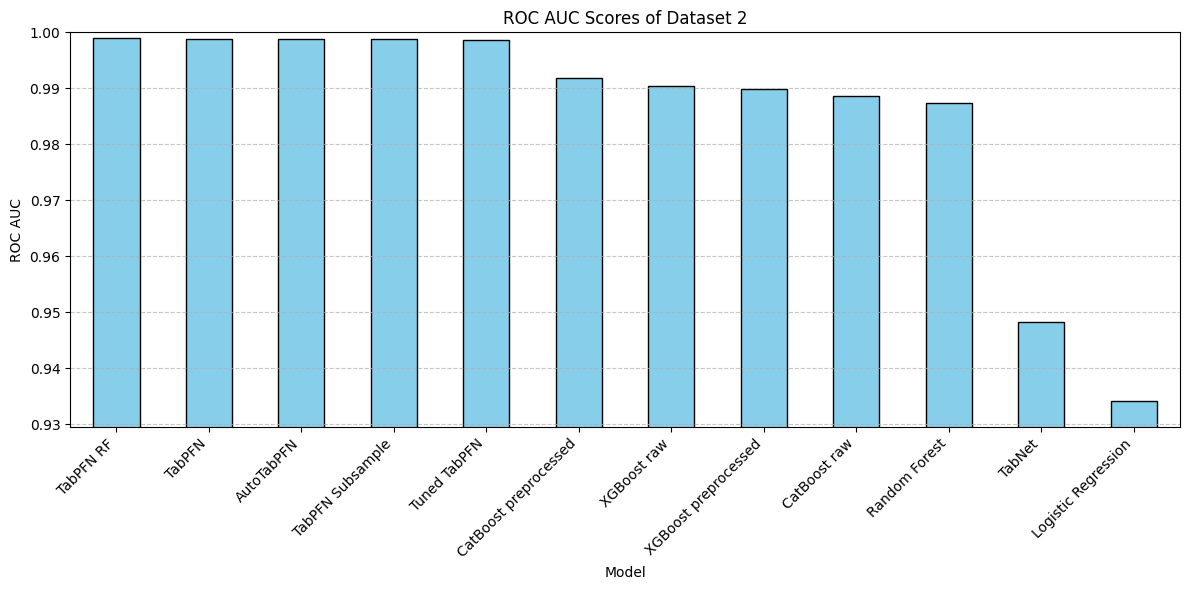

<Axes: title={'center': 'ROC AUC Scores of Dataset 2'}, xlabel='Model', ylabel='ROC AUC'>

In [ ]:
all_metrics_dataset_2 = {
    **metrics_preprocessed_dataset_2,
    **metrics_raw_dataset_2
}

# Plot ROC AUC scores for all models on Dataset 2
plot_roc_auc(all_metrics_dataset_2, dataset_name="Dataset 2")

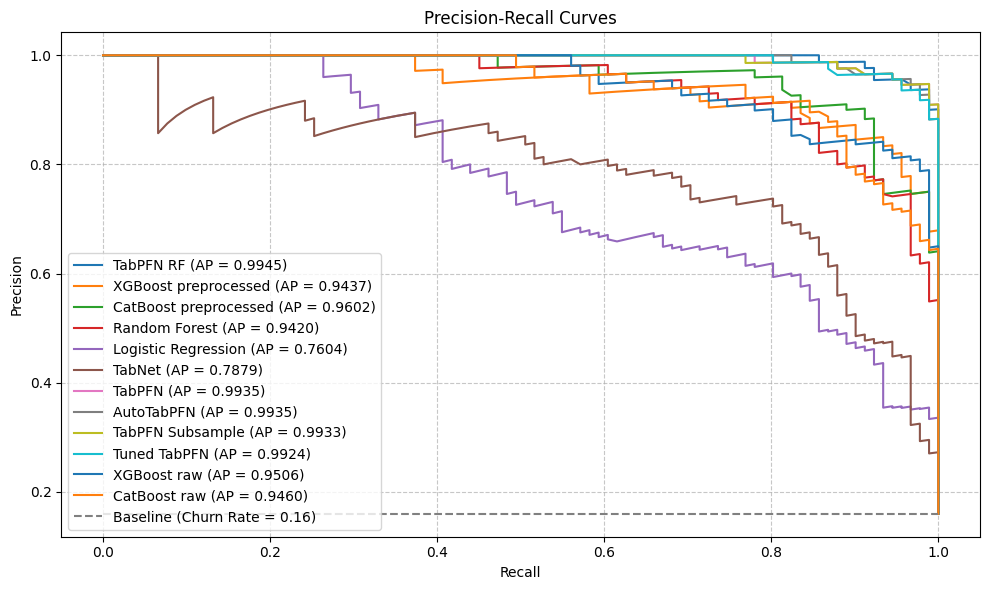

In [ ]:
all_model_probas_dataset_2 = {
    **model_probas_preprocessed_dataset_2,
    **model_probas_raw_dataset_2
}

# Plot precision-recall curves for all models and add churn rate as baseline
plot_precision_recall_curves(all_model_probas_dataset_2, y_test)

###**DATASET 3**###

In [ ]:
# Upload the third dataset
uploaded = files.upload()

pd.set_option('display.max_columns', None)
hr_data = pd.read_csv('HR_Churn.csv')
hr_data.head()

Saving HR_Churn.csv to HR_Churn (1).csv


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


### **Data exploration and preparation** ###

##### **Exploration** #####

In [ ]:
# Rename columns: insert underscore before uppercase letters and convert all to lowercase
df_hr = hr_data.copy()

df_hr.columns = (df_hr.columns \
    .str.replace(r'(?<=[a-z])(?=[A-Z])', '_', regex=True)
    .str.lower()
)

In [ ]:
# Check data types and missing values in the dataset
df_hr.info()
# No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         1470 non-null   int64 
 1   attrition                   1470 non-null   object
 2   business_travel             1470 non-null   object
 3   daily_rate                  1470 non-null   int64 
 4   department                  1470 non-null   object
 5   distance_from_home          1470 non-null   int64 
 6   education                   1470 non-null   int64 
 7   education_field             1470 non-null   object
 8   employee_count              1470 non-null   int64 
 9   employee_number             1470 non-null   int64 
 10  environment_satisfaction    1470 non-null   int64 
 11  gender                      1470 non-null   object
 12  hourly_rate                 1470 non-null   int64 
 13  job_involvement             1470 non-null   int6

In [ ]:
# Check unique values in each column to detect inconsistencies, unexpected categorical levels, potential problems like typos
for col in df_hr.columns:
    print(f"Column: {col}")
    print(np.sort(df_hr[col].unique()))
    print("-" * 40)

Column: age
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
----------------------------------------
Column: attrition
['No' 'Yes']
----------------------------------------
Column: business_travel
['Non-Travel' 'Travel_Frequently' 'Travel_Rarely']
----------------------------------------
Column: daily_rate
[ 102  103  104  105  106  107  109  111  115  116  117  118  119  120
  121  124  125  128  129  130  131  132  134  135  136  138  140  141
  142  143  144  145  146  147  148  150  152  153  154  155  156  157
  160  161  163  164  167  168  170  172  174  176  177  179  180  181
  182  185  188  189  192  193  194  195  196  199  200  201  202  203
  204  205  206  207  208  210  211  213  216  217  218  219  224  228
  230  231  232  234  237  238  240  241  243  244  247  248  249  251
  252  253  254  256  258  261  263  264  265  266  267  268  269  271
  277  279  280  282  285  286  287  288

In [ ]:
# Check duplicates in the dataset
df_hr.duplicated().sum()
# No duplicates

np.int64(0)

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['employee_count', 'employee_number', 'over18', 'standard_hours']
df_hr.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Convert variables to appropriate data types to facilitate later analysis and feature selection

# 1. Binary mapping of the target variable
df_hr['attrition'] = df_hr['attrition'].map({'No': 0, 'Yes': 1})

# 2. Identify categorical features as columns with 'object' datatype
columns_with_object_datatype = df_hr.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to 'category' dtype
for col in columns_with_object_datatype:
    df_hr[col] = df_hr[col].astype('category')

# 3. Convert categorical columns that have numerical datatype to 'category'
categoricals = [
    'education', 'environment_satisfaction',
    'job_involvement', 'job_level', 'job_satisfaction',
    'performance_rating', 'relationship_satisfaction',
    'stock_option_level', 'work_life_balance'
]

df_hr[categoricals] = df_hr[categoricals].astype('category')

In [ ]:
# Identify categorical and numerical features
categorical_columns = df_hr.drop(columns='attrition').select_dtypes(include='category').columns.tolist()
numerical_features = df_hr.select_dtypes(include=['float64', 'int64']).drop(columns='attrition').columns.tolist()

# Get column indices of categorical features (needed for TabNet embeddings)
categorical_feature_indices = [df_hr.drop(columns='attrition').columns.get_loc(col) for col in categorical_columns]

In [ ]:
df_hr.describe()
# The target variable 'attirtion' appears to be imbalanced
# Numerical variables are on very different scales, which may require scaling before modeling

,age,attrition,daily_rate,distance_from_home,hourly_rate,monthly_income,monthly_rate,num_companies_worked,percent_salary_hike,total_working_years,training_times_last_year,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,802.485714,9.192517,65.891156,6502.931293,14313.103401,2.693197,15.209524,11.279592,2.799320,7.008163,4.229252,2.187755,4.123129
std,9.135373,0.367863,403.509100,8.106864,20.329428,4707.956783,7117.786044,2.498009,3.659938,7.780782,1.289271,6.126525,3.623137,3.222430,3.568136
min,18.000000,0.000000,102.000000,1.000000,30.000000,1009.000000,2094.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,465.000000,2.000000,48.000000,2911.000000,8047.000000,1.000000,12.000000,6.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,802.000000,7.000000,66.000000,4919.000000,14235.500000,2.000000,14.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,1157.000000,14.000000,83.750000,8379.000000,20461.500000,4.000000,18.000000,15.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1.000000,1499.000000,29.000000,100.000000,19999.000000,26999.000000,9.000000,25.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000


##### **Preparation of the raw data (for TabPFN and extensions, XGBoost, CatBoost)** #####

In [ ]:
# Save a copy of the raw data for use in models that accept categorical features directly
df_raw = df_hr.copy()
df_raw

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,No,17,3,3,1,17,3,3,5,2,0,3
1466,39,0,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,No,15,3,1,1,9,5,3,7,7,1,7
1467,27,0,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Yes,20,4,2,1,6,0,3,6,2,0,3
1468,49,0,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,No,14,3,4,0,17,3,2,9,6,0,8


In [ ]:
X = df_raw.drop(columns=['attrition'])
y = df_raw['attrition']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### **Preparation of label encoded (tree-based models) and scaled data (for TabNet model)** #####

In [ ]:
# Create a copy of the preprocessed DataFrame for label encoding
df_label_encoded = df_hr.copy()

# Apply Label Encoding to all categorical columns
le = LabelEncoder()
for col in categorical_columns:
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])

df_label_encoded

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,41,1,2,1102,2,1,1,1,1,0,94,2,1,7,3,2,5993,19479,8,1,11,0,0,0,8,0,0,6,4,0,5
1,49,0,1,279,1,8,0,1,2,1,61,1,1,6,1,1,5130,24907,1,0,23,1,3,1,10,3,2,10,7,1,7
2,37,1,2,1373,1,2,1,4,3,1,92,1,0,2,2,2,2090,2396,6,1,15,0,1,0,7,3,2,0,0,0,0
3,33,0,1,1392,1,3,3,1,3,0,56,2,0,6,2,1,2909,23159,1,1,11,0,2,0,8,3,2,8,7,3,0
4,27,0,2,591,1,2,0,3,0,1,40,2,0,2,1,1,3468,16632,9,0,12,0,3,1,6,3,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,1,884,1,23,1,3,2,1,41,3,1,2,3,1,2571,12290,4,0,17,0,2,1,17,3,2,5,2,0,3
1466,39,0,2,613,1,6,0,3,3,1,42,1,2,0,0,1,9991,21457,4,0,15,0,0,1,9,5,2,7,7,1,7
1467,27,0,2,155,1,4,2,1,1,1,87,3,1,4,1,1,6142,5174,1,1,20,1,1,1,6,0,2,6,2,0,3
1468,49,0,1,1023,2,2,2,3,3,1,63,1,1,7,1,1,5390,13243,2,0,14,0,3,0,17,3,1,9,6,0,8


In [ ]:
X = df_label_encoded.drop(columns=['attrition'])
y = df_label_encoded['attrition']

X_train_label_encoded, X_test_label_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Rescale numerical features in the label-encoded data using StandardScaler
X_train_label_encoded_scaled = X_train_label_encoded.copy()
X_test_label_encoded_scaled = X_test_label_encoded.copy()

scaler = StandardScaler()
X_train_label_encoded_scaled[numerical_features] = scaler.fit_transform(X_train_label_encoded_scaled[numerical_features])
X_test_label_encoded_scaled[numerical_features] = scaler.transform(X_test_label_encoded_scaled[numerical_features])

##### **Preparation of the One-Hot-encoded and scaled data (for Logistic Regression)** #####

In [ ]:
# Make a copy of the label-encoded DataFrame to apply one-hot encoding
df_encoded = df_label_encoded.copy()

# Define ordinal features to exclude from one-hot encoding
ordinal_exclude = [
    'education', 'environment_satisfaction', 'job_involvement', 'job_level',
    'job_satisfaction', 'performance_rating', 'relationship_satisfaction',
    'work_life_balance'
]

# Determine which columns to one-hot encode (categorical but not ordinal)
one_hot_columns = [col for col in categorical_columns if col not in ordinal_exclude]

# Apply one-hot encoding to selected columns, drop the first level
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_columns, drop_first=True)

# Convert True/False columns to 1/0
df_encoded = df_encoded.replace({True: 1, False: 0})

df_encoded

,age,attrition,daily_rate,distance_from_home,education,environment_satisfaction,hourly_rate,job_involvement,job_level,job_satisfaction,monthly_income,monthly_rate,num_companies_worked,percent_salary_hike,performance_rating,relationship_satisfaction,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,business_travel_1,business_travel_2,department_1,department_2,education_field_1,education_field_2,education_field_3,education_field_4,education_field_5,gender_1,job_role_1,job_role_2,job_role_3,job_role_4,job_role_5,job_role_6,job_role_7,job_role_8,marital_status_1,marital_status_2,over_time_1,stock_option_level_1,stock_option_level_2,stock_option_level_3
0,41,1,1102,1,1,1,94,2,1,3,5993,19479,8,11,0,0,8,0,0,6,4,0,5,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0
1,49,0,279,8,0,2,61,1,1,1,5130,24907,1,23,1,3,10,3,2,10,7,1,7,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,37,1,1373,2,1,3,92,1,0,2,2090,2396,6,15,0,1,7,3,2,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0
3,33,0,1392,3,3,3,56,2,0,2,2909,23159,1,11,0,2,8,3,2,8,7,3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
4,27,0,591,2,0,0,40,2,0,1,3468,16632,9,12,0,3,6,3,2,2,2,2,2,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,1,2,41,3,1,3,2571,12290,4,17,0,2,17,3,2,5,2,0,3,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0
1466,39,0,613,6,0,3,42,1,2,0,9991,21457,4,15,0,0,9,5,2,7,7,1,7,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1467,27,0,155,4,2,1,87,3,1,1,6142,5174,1,20,1,1,6,0,2,6,2,0,3,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0
1468,49,0,1023,2,2,3,63,1,1,1,5390,13243,2,14,0,3,17,3,1,9,6,0,8,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [ ]:
X = df_encoded.drop(columns=['attrition'])
y = df_encoded['attrition']

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_encoded_scaled = X_train_encoded.copy()
X_test_encoded_scaled = X_test_encoded.copy()

scaler = StandardScaler()
X_train_encoded_scaled[numerical_features] = scaler.fit_transform(X_train_encoded_scaled[numerical_features])
X_test_encoded_scaled[numerical_features] = scaler.transform(X_test_encoded_scaled[numerical_features])

### **Modelling the results** ###

In [ ]:
# Evaluate all models using preprocessed data (encoded, scaled, or label-encoded)
metrics_preprocessed_dataset_3, training_times_preprocessed_dataset_3, model_probas_preprocessed_dataset_3 = evaluate_models_on_preprocessed_data(
    X_train_label_encoded, X_test_label_encoded,
    X_train_encoded_scaled, X_test_encoded_scaled,
    X_train_label_encoded_scaled, X_test_label_encoded_scaled,
    y_train, y_test
)


Training and evaluating TabPFN RF...
TabPFN RF Test ROC AUC: 0.8151 | PR AUC: 0.5172 | Time: 0.34 sec

Training and evaluating XGBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost preprocessed Test ROC AUC: 0.7572 | PR AUC: 0.3799 | Time: 3.27 sec

Training and evaluating CatBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost preprocessed Test ROC AUC: 0.7716 | PR AUC: 0.4753 | Time: 12.89 sec

Training and evaluating Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest Test ROC AUC: 0.7376 | PR AUC: 0.3772 | Time: 3.05 sec

Training and evaluating Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[I 2025-06-15 22:12:22,460] A new study created in memory with name: no-name-d6a5ec0d-29a6-47ee-a570-b868823e542a


Logistic Regression Test ROC AUC: 0.8009 | PR AUC: 0.5312 | Time: 3.51 sec

Training and evaluating TabNet...

Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_auc = 0.66684


[I 2025-06-15 22:12:27,044] Trial 0 finished with value: 0.6668367346938775 and parameters: {'n_d': 29, 'n_a': 62, 'n_steps': 8, 'gamma': 1.5986584841970366, 'lambda_sparse': 0.00015601864044243653, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.34780869685222476, 'lr': 0.015930522616241012}. Best is trial 0 with value: 0.6668367346938775.
[I 2025-06-15 22:12:29,415] Trial 1 finished with value: 0.585204081632653 and parameters: {'n_d': 48, 'n_a': 9, 'n_steps': 10, 'gamma': 1.8324426408004217, 'lambda_sparse': 0.00021233911067827617, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.1286544747542197, 'lr': 0.01120760621186057}. Best is trial 0 with value: 0.6668367346938775.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.5852


[I 2025-06-15 22:12:31,122] Trial 2 finished with value: 0.5104591836734694 and parameters: {'n_d': 32, 'n_a': 24, 'n_steps': 7, 'gamma': 1.139493860652042, 'lambda_sparse': 0.00029214464853521814, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.31621862494327535, 'lr': 0.002508115686045232}. Best is trial 0 with value: 0.6668367346938775.



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.51046


[I 2025-06-15 22:12:32,955] Trial 3 finished with value: 0.6406887755102041 and parameters: {'n_d': 37, 'n_a': 41, 'n_steps': 3, 'gamma': 1.6075448519014384, 'lambda_sparse': 0.00017052412368729152, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.38659649289907816, 'lr': 0.041380401125610165}. Best is trial 0 with value: 0.6668367346938775.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.64069


[I 2025-06-15 22:12:34,879] Trial 4 finished with value: 0.5831632653061225 and parameters: {'n_d': 25, 'n_a': 13, 'n_steps': 8, 'gamma': 1.4401524937396013, 'lambda_sparse': 0.00012203823484477882, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36463495681072505, 'lr': 0.0032927591344236173}. Best is trial 0 with value: 0.6668367346938775.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.58316

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.57589


[I 2025-06-15 22:12:38,311] Trial 5 finished with value: 0.5758928571428571 and parameters: {'n_d': 45, 'n_a': 25, 'n_steps': 7, 'gamma': 1.5467102793432796, 'lambda_sparse': 0.00018485445552552705, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.3764045872100338, 'lr': 0.06161049539380966}. Best is trial 0 with value: 0.6668367346938775.
[I 2025-06-15 22:12:39,380] Trial 6 finished with value: 0.6584183673469387 and parameters: {'n_d': 42, 'n_a': 60, 'n_steps': 3, 'gamma': 1.1959828624191453, 'lambda_sparse': 4.5227288910538064e-05, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.1158261223918194, 'lr': 0.045443839603360174}. Best is trial 0 with value: 0.6668367346938775.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.65842


[I 2025-06-15 22:12:43,996] Trial 7 finished with value: 0.6565051020408164 and parameters: {'n_d': 28, 'n_a': 24, 'n_steps': 7, 'gamma': 1.1409242249747626, 'lambda_sparse': 0.0008021969807540396, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.3111754600256964, 'lr': 0.002497073714505273}. Best is trial 0 with value: 0.6668367346938775.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.65651


[I 2025-06-15 22:12:46,461] Trial 8 finished with value: 0.6739795918367346 and parameters: {'n_d': 8, 'n_a': 54, 'n_steps': 8, 'gamma': 1.7290071680409873, 'lambda_sparse': 0.0007712703466859458, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.05518893321480059, 'lr': 0.05323617594751501}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.67398


[I 2025-06-15 22:12:47,953] Trial 9 finished with value: 0.6447704081632654 and parameters: {'n_d': 43, 'n_a': 26, 'n_steps': 3, 'gamma': 1.3109823217156622, 'lambda_sparse': 0.00032518332202674706, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.35601296960476736, 'lr': 0.008798929749689027}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.64477


[I 2025-06-15 22:12:51,088] Trial 10 finished with value: 0.5794642857142857 and parameters: {'n_d': 9, 'n_a': 48, 'n_steps': 5, 'gamma': 1.936648753257398, 'lambda_sparse': 0.0009792234821987594, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.014334610080857409, 'lr': 0.08682127224044867}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.57946


[I 2025-06-15 22:12:54,645] Trial 11 finished with value: 0.6691326530612245 and parameters: {'n_d': 63, 'n_a': 64, 'n_steps': 9, 'gamma': 1.6987430422866403, 'lambda_sparse': 0.0005697193088699224, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.2335834812839793, 'lr': 0.015253421517969643}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.66913


[I 2025-06-15 22:12:59,119] Trial 12 finished with value: 0.6551020408163265 and parameters: {'n_d': 61, 'n_a': 51, 'n_steps': 10, 'gamma': 1.7537613309272395, 'lambda_sparse': 0.0006090738634337444, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.24296414284216755, 'lr': 0.020857821171616043}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.6551


[I 2025-06-15 22:13:01,963] Trial 13 finished with value: 0.5660714285714286 and parameters: {'n_d': 13, 'n_a': 53, 'n_steps': 9, 'gamma': 1.730911302303416, 'lambda_sparse': 0.0005831424348812113, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.20386330350823242, 'lr': 0.006054923767484892}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.56607


[I 2025-06-15 22:13:03,392] Trial 14 finished with value: 0.5797193877551021 and parameters: {'n_d': 63, 'n_a': 63, 'n_steps': 5, 'gamma': 1.9960169893612132, 'lambda_sparse': 0.0007520153757097964, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.0427811504489581, 'lr': 0.025695327964024472}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.57972


[I 2025-06-15 22:13:06,538] Trial 15 finished with value: 0.6192602040816326 and parameters: {'n_d': 17, 'n_a': 41, 'n_steps': 9, 'gamma': 1.3882706745672633, 'lambda_sparse': 0.000448548056890076, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.19812393215891086, 'lr': 0.030777856901101092}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.61926


[I 2025-06-15 22:13:09,508] Trial 16 finished with value: 0.4876275510204082 and parameters: {'n_d': 55, 'n_a': 55, 'n_steps': 9, 'gamma': 1.701864030052493, 'lambda_sparse': 0.0007637473949148529, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.1386124291801603, 'lr': 0.001062572149732749}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_auc = 0.48763


[I 2025-06-15 22:13:13,520] Trial 17 finished with value: 0.649234693877551 and parameters: {'n_d': 20, 'n_a': 46, 'n_steps': 6, 'gamma': 1.8515173861900567, 'lambda_sparse': 0.0009278557203823803, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.26161489885972455, 'lr': 0.09893194262905022}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.64923


[I 2025-06-15 22:13:16,137] Trial 18 finished with value: 0.6075255102040816 and parameters: {'n_d': 57, 'n_a': 32, 'n_steps': 8, 'gamma': 1.0217294932636678, 'lambda_sparse': 0.0006282213481219772, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.09386040215043634, 'lr': 0.01416673575699266}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.60753


[I 2025-06-15 22:13:18,888] Trial 19 finished with value: 0.48252551020408163 and parameters: {'n_d': 51, 'n_a': 57, 'n_steps': 10, 'gamma': 1.676109975447065, 'lambda_sparse': 0.000462427348344883, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.1687690899791833, 'lr': 0.004261748882098931}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.48253


[I 2025-06-15 22:13:20,082] Trial 20 finished with value: 0.5690051020408163 and parameters: {'n_d': 22, 'n_a': 64, 'n_steps': 6, 'gamma': 1.4716050217416643, 'lambda_sparse': 0.0008801205607917681, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.0677504096134307, 'lr': 0.007812634833498679}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_auc = 0.56901


[I 2025-06-15 22:13:22,479] Trial 21 finished with value: 0.6491071428571429 and parameters: {'n_d': 8, 'n_a': 58, 'n_steps': 8, 'gamma': 1.5842599484550877, 'lambda_sparse': 0.0007002878332497945, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.25543885012316403, 'lr': 0.016272451231674485}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.64911


[I 2025-06-15 22:13:24,547] Trial 22 finished with value: 0.6336734693877552 and parameters: {'n_d': 37, 'n_a': 63, 'n_steps': 8, 'gamma': 1.8214488133687734, 'lambda_sparse': 0.0003588892695932592, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.3086485413717237, 'lr': 0.03566837153491633}. Best is trial 8 with value: 0.6739795918367346.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.63367


[I 2025-06-15 22:13:31,103] Trial 23 finished with value: 0.68125 and parameters: {'n_d': 31, 'n_a': 50, 'n_steps': 9, 'gamma': 1.623563228294331, 'lambda_sparse': 0.0005229425463574492, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.16767211834735168, 'lr': 0.019115939950771623}. Best is trial 23 with value: 0.68125.



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.68125


[I 2025-06-15 22:13:33,626] Trial 24 finished with value: 0.5769132653061224 and parameters: {'n_d': 34, 'n_a': 46, 'n_steps': 9, 'gamma': 1.6435797496710338, 'lambda_sparse': 0.0005530386004440393, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16207099894498547, 'lr': 0.06521396180427304}. Best is trial 23 with value: 0.68125.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.57691


[I 2025-06-15 22:13:36,899] Trial 25 finished with value: 0.6479591836734695 and parameters: {'n_d': 14, 'n_a': 41, 'n_steps': 9, 'gamma': 1.5252990730673806, 'lambda_sparse': 0.0006713230505310126, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.23303980395144233, 'lr': 0.020740468454335855}. Best is trial 23 with value: 0.68125.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.64796


[I 2025-06-15 22:13:40,002] Trial 26 finished with value: 0.6292729591836735 and parameters: {'n_d': 40, 'n_a': 51, 'n_steps': 10, 'gamma': 1.794774844368306, 'lambda_sparse': 0.000515212549507696, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.07576953085232087, 'lr': 0.05033667472894934}. Best is trial 23 with value: 0.68125.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_auc = 0.62927


[I 2025-06-15 22:13:42,730] Trial 27 finished with value: 0.6748724489795919 and parameters: {'n_d': 52, 'n_a': 36, 'n_steps': 9, 'gamma': 1.403029385536061, 'lambda_sparse': 0.00040053229881972867, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.17366729913343418, 'lr': 0.02619237084707642}. Best is trial 23 with value: 0.68125.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_auc = 0.67487


[I 2025-06-15 22:13:46,198] Trial 28 finished with value: 0.6899234693877551 and parameters: {'n_d': 48, 'n_a': 32, 'n_steps': 7, 'gamma': 1.3494776330655467, 'lambda_sparse': 0.00037768869337068177, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.1660966366294173, 'lr': 0.027464318160771453}. Best is trial 28 with value: 0.6899234693877551.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.68992


[I 2025-06-15 22:13:50,945] Trial 29 finished with value: 0.6216836734693878 and parameters: {'n_d': 50, 'n_a': 33, 'n_steps': 5, 'gamma': 1.3245599068054121, 'lambda_sparse': 0.0003814096894371717, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.1777476812489856, 'lr': 0.02517021837117672}. Best is trial 28 with value: 0.6899234693877551.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.62168

Early stopping occurred at epoch 24 with best_epoch = 19 and best_train_auc = 0.66472
TabNet Test ROC AUC: 0.6534 | PR AUC: 0.2701 | Time: 111.93 sec


In [ ]:
# Evaluate all models that support raw input data
metrics_raw_dataset_3, training_times_raw_dataset_3, model_probas_raw_dataset_3 = evaluate_models_on_raw_data(
    X_train_raw, X_test_raw,
    y_train, y_test,
    categorical_feature_indices,
    categorical_columns
)


Training and evaluating TabPFN...
TabPFN Test ROC AUC: 0.7886 | PR AUC: 0.4741 | Time: 0.20 sec

Training and evaluating AutoTabPFN...


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231), np.float64(-0.8353473384148231

AutoTabPFN Test ROC AUC: 0.7908 | PR AUC: 0.5216 | Time: 367.67 sec

Training and evaluating TabPFN Subsample...
TabPFN Subsample Test ROC AUC: 0.7885 | PR AUC: 0.4742 | Time: 0.18 sec

Training and evaluating Tuned TabPFN...
Tuned TabPFN Test ROC AUC: 0.7964 | PR AUC: 0.4470 | Time: 23.27 sec

Training and evaluating XGBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost raw Test ROC AUC: 0.7863 | PR AUC: 0.4142 | Time: 3.49 sec

Training and evaluating CatBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost raw Test ROC AUC: 0.7541 | PR AUC: 0.4076 | Time: 33.61 sec


### **Plotting the results** ###

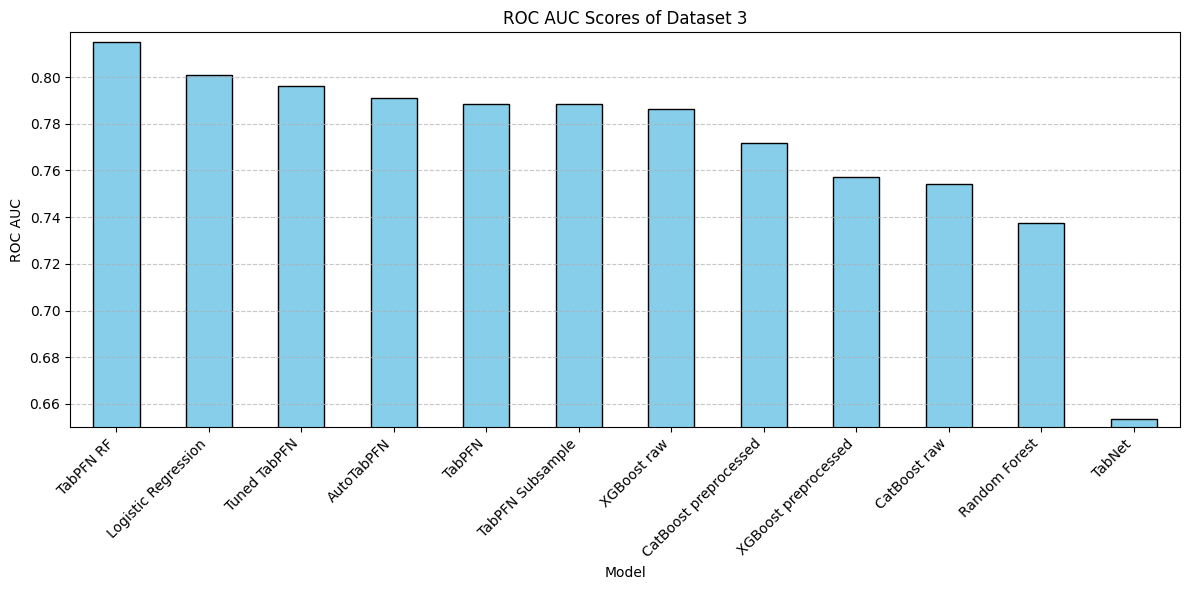

<Axes: title={'center': 'ROC AUC Scores of Dataset 3'}, xlabel='Model', ylabel='ROC AUC'>

In [ ]:
all_metrics_dataset_3 = {
    **metrics_preprocessed_dataset_3,
    **metrics_raw_dataset_3
}

# Plot ROC AUC scores for all models on Dataset 3
plot_roc_auc(all_metrics_dataset_3, dataset_name="Dataset 3")

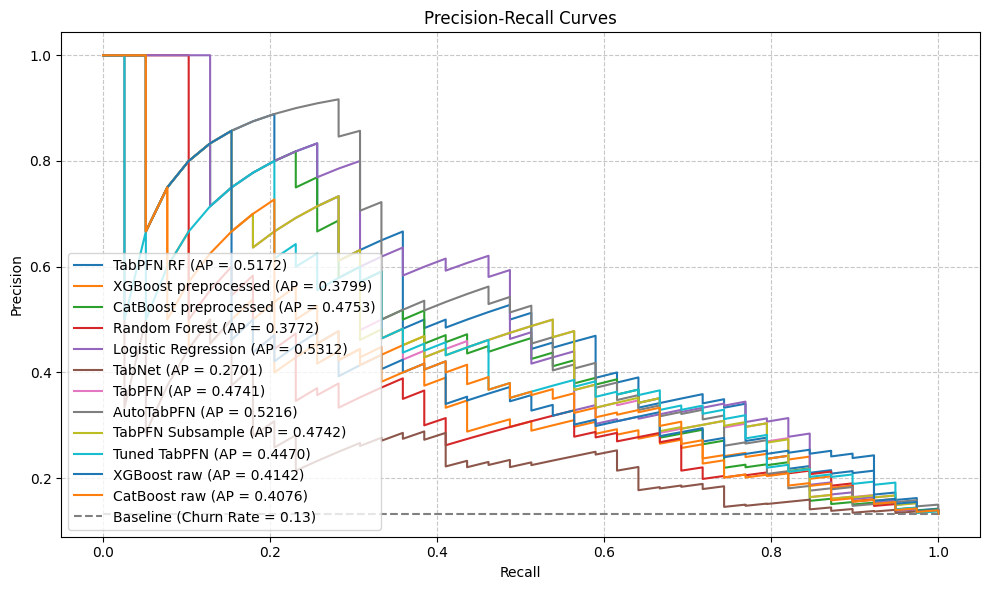

In [ ]:
all_model_probas_dataset_3 = {
    **model_probas_preprocessed_dataset_3,
    **model_probas_raw_dataset_3
}

# Plot precision-recall curves for all models and add churn rate as baseline
plot_precision_recall_curves(all_model_probas_dataset_3, y_test)

###**DATASET 4**###

In [ ]:
# Upload the fourth dataset
uploaded = files.upload()

pd.set_option('display.max_columns', None)
riester = pd.read_csv('riester.csv', delimiter=";")
riester.head()

Saving riester.csv to riester (2).csv


,AendGrund,Anspruch,Kuerzung,Tg,Fg,Geo,Geschlecht,L,AendDatTage,Alter,LFZ,RestLFZ,ZB,DZA,KE,Eart,Kinder,VTAnz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.074035,0.88,0.818182,-0.960784,0,1,0,1,0.0,1.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-0.985722,0.52,-0.454545,-0.490196,1,1,0,1,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.074035,0.60,0.636364,-0.686275,0,1,0,1,0.0,1.0
3,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,-0.938128,0.40,-0.636364,-0.490196,0,1,0,1,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.074035,0.52,0.818182,-0.568627,0,1,0,1,0.0,1.0


### **Data exploration and preparation** ###

##### **Exploration** #####

In [ ]:
# Rename columns: insert underscore before uppercase letters and convert all to lowercase
df_riester = riester.copy()

df_riester.columns = (df_riester.columns \
    .str.replace(r'(?<=[a-z])(?=[A-Z])', '_', regex=True)
    .str.lower()
)

In [ ]:
df_riester.info()
# We see that all variables have numerical values
# No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155056 entries, 0 to 155055
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   aend_grund     155056 non-null  float64
 1   anspruch       155056 non-null  float64
 2   kuerzung       155056 non-null  float64
 3   tg             155056 non-null  float64
 4   fg             155056 non-null  float64
 5   geo            155056 non-null  float64
 6   geschlecht     155056 non-null  float64
 7   l              155056 non-null  float64
 8   aend_dat_tage  155056 non-null  float64
 9   alter          155056 non-null  float64
 10  lfz            155056 non-null  float64
 11  rest_lfz       155056 non-null  float64
 12  zb             155056 non-null  int64  
 13  dza            155056 non-null  int64  
 14  ke             155056 non-null  int64  
 15  eart           155056 non-null  int64  
 16  kinder         155056 non-null  float64
 17  vtanz          155056 non-nul

In [ ]:
# Check unique values in each column to understand value distributions and detect inconsistencies
for col in df_riester.columns:
    print(f"Column: {col}")
    print(np.sort(df_riester[col].unique()))
    print("-" * 40)

Column: aend_grund
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
----------------------------------------
Column: anspruch
[0. 1. 2. 3. 4.]
----------------------------------------
Column: kuerzung
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
----------------------------------------
Column: tg
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
----------------------------------------
Column: fg
[0. 1. 2. 3. 4.]
----------------------------------------
Column: geo
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.]
----------------------------------------
Column: geschlecht
[0. 1. 2.]
----------------------------------------
Column: l
[0. 1. 2.]
----------------------------------------
Column: aend_dat_tage
[-1.         -0.99947118 -0.99894236 ...  0.90375463  0.95

In [ ]:
# Check duplicates in the dataset
df_riester.duplicated().sum()

np.int64(23266)

In [ ]:
# Drop duplicated values
df_riester.drop_duplicates(inplace=True)

In [ ]:
# Convert selected columns to integers (some models can't handle float values in categorical features)
cols_to_convert = [
    "aend_grund", "anspruch", "kuerzung", "tg", "fg", "geo",
    "geschlecht", "l", "kinder", 'vtanz'
]

for col in cols_to_convert:
    df_riester[col] = pd.to_numeric(df_riester[col], errors='coerce').fillna(0).astype(int)

In [ ]:
# Explicitly convert specific columns to categorical
categoricals = [
    'aend_grund', 'zb', 'dza',
    'anspruch', 'kuerzung', 'tg', 'fg',
    'eart', 'vtanz', 'l', 'geschlecht'
]
df_riester[categoricals] = df_riester[categoricals].astype('category')

In [ ]:
df_riester.describe()
# The target variable 'ke' appears to be imbalanced
# Numerical variables (geo, kinder) are not scaled

,geo,aend_dat_tage,alter,lfz,rest_lfz,ke,kinder
count,131790.000000,131790.000000,131790.000000,131790.000000,131790.000000,131790.000000,131790.000000
mean,15.545375,-0.695404,-0.046158,-0.104938,0.011228,0.023257,0.422156
std,16.778412,0.281512,0.428774,0.515228,0.441844,0.150718,0.870540
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,2.000000,-0.880487,-0.400000,-0.454545,-0.333333,0.000000,0.000000
50%,9.000000,-0.776309,-0.040000,-0.090909,-0.019608,0.000000,0.000000
75%,26.000000,-0.651507,0.280000,0.090909,0.372549,0.000000,0.000000
max,71.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000


### **Data preparation** ###

In [ ]:
# Set a seed for reproducibility
RANDOM_SEED = 42

# Draw a random sample of 10,000 rows
df_sampled = df_riester.sample(n=10000, random_state=RANDOM_SEED)

In [ ]:
# Identify categorical and numerical features
categorical_columns = df_sampled.drop(columns='ke').select_dtypes(include='category').columns.tolist()
numerical_features = df_sampled.select_dtypes(include=['int64']).drop(columns='ke').columns.tolist()

# Get column indices of categorical features (needed for TabNet embeddings)
categorical_feature_indices = [df_sampled.drop(columns='ke').columns.get_loc(col) for col in categorical_columns]

In [ ]:
df_sampled.describe()
# Mostly all features have a similar distribution compared to the original data

,geo,aend_dat_tage,alter,lfz,rest_lfz,ke,kinder
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,15.654200,-0.694142,-0.040028,-0.107345,0.005031,0.022700,0.424200
std,16.799275,0.280665,0.430209,0.515609,0.442968,0.148953,0.863903
min,0.000000,-1.000000,-0.960000,-1.000000,-1.000000,0.000000,0.000000
25%,2.000000,-0.877314,-0.400000,-0.454545,-0.333333,0.000000,0.000000
50%,9.000000,-0.770492,-0.040000,-0.090909,-0.019608,0.000000,0.000000
75%,26.000000,-0.651375,0.320000,0.090909,0.372549,0.000000,0.000000
max,65.000000,0.324696,0.960000,1.000000,1.000000,1.000000,8.000000


##### **Preparation of the raw data (for TabPFN and extensions, XGBoost, CatBoost)** #####

In [ ]:
# Save a copy of the raw data for use in models that accept categorical features directly
df_raw = df_sampled.copy()
df_raw

,aend_grund,anspruch,kuerzung,tg,fg,geo,geschlecht,l,aend_dat_tage,alter,lfz,rest_lfz,zb,dza,ke,eart,kinder,vtanz
44994,2,2,8,1,0,0,1,1,-0.832364,-0.28,-0.272727,0.215686,0,1,0,0,0,1
73715,1,0,1,2,0,10,1,0,-0.938128,0.32,-0.818182,-0.294118,1,1,0,1,2,1
51404,2,0,0,5,0,2,1,1,-0.747753,-0.36,-0.090909,0.294118,1,1,0,1,0,1
119667,1,1,4,0,0,3,2,0,-0.745637,0.08,0.818182,-0.333333,1,0,0,0,0,1
118192,2,0,1,3,0,1,0,1,-0.758329,0.40,-0.818182,-0.450980,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80426,1,0,0,0,0,4,0,0,-0.924379,0.00,0.636364,-0.137255,0,1,0,0,0,1
34100,2,0,0,4,0,27,1,0,-0.985193,0.72,0.454545,-0.803922,0,1,0,0,0,1
117568,1,1,4,0,1,3,2,0,-0.745637,0.32,1.000000,-0.372549,1,0,0,1,0,1
87977,1,0,1,2,2,1,1,0,-0.946060,-0.56,-0.818182,0.529412,0,1,0,0,0,1


In [ ]:
X = df_raw.drop(columns=['ke'])
y = df_raw['ke']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### **Preparation of label encoded (for tree-based models) and scaled data (for TabNet model)** #####

In [ ]:
# Create a copy of the preprocessed DataFrame for label encoding
df_label_encoded = df_sampled.copy()

# Apply Label Encoding to all categorical columns
le = LabelEncoder()
for col in categorical_columns:
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col])

df_label_encoded

,aend_grund,anspruch,kuerzung,tg,fg,geo,geschlecht,l,aend_dat_tage,alter,lfz,rest_lfz,zb,dza,ke,eart,kinder,vtanz
44994,2,2,8,1,0,0,1,1,-0.832364,-0.28,-0.272727,0.215686,0,1,0,0,0,0
73715,1,0,1,2,0,10,1,0,-0.938128,0.32,-0.818182,-0.294118,1,1,0,1,2,0
51404,2,0,0,5,0,2,1,1,-0.747753,-0.36,-0.090909,0.294118,1,1,0,1,0,0
119667,1,1,4,0,0,3,2,0,-0.745637,0.08,0.818182,-0.333333,1,0,0,0,0,0
118192,2,0,1,3,0,1,0,1,-0.758329,0.40,-0.818182,-0.450980,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80426,1,0,0,0,0,4,0,0,-0.924379,0.00,0.636364,-0.137255,0,1,0,0,0,0
34100,2,0,0,4,0,27,1,0,-0.985193,0.72,0.454545,-0.803922,0,1,0,0,0,0
117568,1,1,4,0,1,3,2,0,-0.745637,0.32,1.000000,-0.372549,1,0,0,1,0,0
87977,1,0,1,2,2,1,1,0,-0.946060,-0.56,-0.818182,0.529412,0,1,0,0,0,0


In [ ]:
X = df_label_encoded.drop(columns=['ke'])
y = df_label_encoded['ke']

X_train_label_encoded, X_test_label_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Rescale numerical features in the label-encoded data using StandardScaler
X_train_label_encoded_scaled = X_train_label_encoded.copy()
X_test_label_encoded_scaled = X_test_label_encoded.copy()

scaler = StandardScaler()
X_train_label_encoded_scaled[numerical_features] = scaler.fit_transform(X_train_label_encoded_scaled[numerical_features])
X_test_label_encoded_scaled[numerical_features] = scaler.transform(X_test_label_encoded_scaled[numerical_features])

##### **Preparation of the One-Hot-encoded and scaled data (for Logistic Regression)** #####

In [ ]:
# Make a copy of the label-encoded DataFrame to apply one-hot encoding
df_encoded = df_label_encoded.copy()

# Apply one-hot encoding to all categorical columns and drop the first level
df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns, drop_first=True)

# Convert True/False columns to 1/0
df_encoded = df_encoded.replace({True: 1, False: 0})

df_encoded

,geo,aend_dat_tage,alter,lfz,rest_lfz,ke,kinder,aend_grund_1,aend_grund_2,aend_grund_3,aend_grund_4,aend_grund_5,aend_grund_6,aend_grund_7,aend_grund_8,aend_grund_9,aend_grund_10,aend_grund_11,aend_grund_12,aend_grund_13,anspruch_1,anspruch_2,kuerzung_1,kuerzung_2,kuerzung_3,kuerzung_4,kuerzung_5,kuerzung_6,kuerzung_7,kuerzung_8,tg_1,tg_2,tg_3,tg_4,tg_5,tg_6,tg_7,tg_8,tg_9,fg_1,fg_2,fg_3,fg_4,geschlecht_1,geschlecht_2,l_1,l_2,zb_1,dza_1,eart_1,vtanz_1,vtanz_2,vtanz_3
44994,0,-0.832364,-0.28,-0.272727,0.215686,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
73715,10,-0.938128,0.32,-0.818182,-0.294118,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0
51404,2,-0.747753,-0.36,-0.090909,0.294118,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0
119667,3,-0.745637,0.08,0.818182,-0.333333,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
118192,1,-0.758329,0.40,-0.818182,-0.450980,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80426,4,-0.924379,0.00,0.636364,-0.137255,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
34100,27,-0.985193,0.72,0.454545,-0.803922,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
117568,3,-0.745637,0.32,1.000000,-0.372549,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
87977,1,-0.946060,-0.56,-0.818182,0.529412,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
X = df_encoded.drop(columns=['ke'])
y = df_encoded['ke']

X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_encoded_scaled = X_train_encoded.copy()
X_test_encoded_scaled = X_test_encoded.copy()

scaler = StandardScaler()
X_train_encoded_scaled[numerical_features] = scaler.fit_transform(X_train_encoded_scaled[numerical_features])
X_test_encoded_scaled[numerical_features] = scaler.transform(X_test_encoded_scaled[numerical_features])

### **Modelling the results** ###

In [ ]:
# Evaluate all models using preprocessed data (encoded, scaled, or label-encoded)
metrics_preprocessed_dataset_4, training_times_preprocessed_dataset_4, model_probas_preprocessed_dataset_4 = evaluate_models_on_preprocessed_data(
    X_train_label_encoded, X_test_label_encoded,
    X_train_encoded_scaled, X_test_encoded_scaled,
    X_train_label_encoded_scaled, X_test_label_encoded_scaled,
    y_train, y_test
)


Training and evaluating TabPFN RF...
TabPFN RF Test ROC AUC: 0.8208 | PR AUC: 0.1150 | Time: 0.97 sec

Training and evaluating XGBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost preprocessed Test ROC AUC: 0.8180 | PR AUC: 0.1190 | Time: 3.38 sec

Training and evaluating CatBoost preprocessed...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost preprocessed Test ROC AUC: 0.8322 | PR AUC: 0.1818 | Time: 10.58 sec

Training and evaluating Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest Test ROC AUC: 0.8344 | PR AUC: 0.1981 | Time: 5.30 sec

Training and evaluating Logistic Regression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[I 2025-06-15 21:48:56,290] A new study created in memory with name: no-name-df769b8c-0024-4ecc-b9cc-09fcf8978944


Logistic Regression Test ROC AUC: 0.8252 | PR AUC: 0.1360 | Time: 24.78 sec

Training and evaluating TabNet...

Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.8192


[I 2025-06-15 21:49:17,712] Trial 0 finished with value: 0.8191973163182377 and parameters: {'n_d': 29, 'n_a': 62, 'n_steps': 8, 'gamma': 1.5986584841970366, 'lambda_sparse': 0.00015601864044243653, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.34780869685222476, 'lr': 0.015930522616241012}. Best is trial 0 with value: 0.8191973163182377.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.77688


[I 2025-06-15 21:49:34,071] Trial 1 finished with value: 0.7768843699745812 and parameters: {'n_d': 48, 'n_a': 9, 'n_steps': 10, 'gamma': 1.8324426408004217, 'lambda_sparse': 0.00021233911067827617, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.1286544747542197, 'lr': 0.01120760621186057}. Best is trial 0 with value: 0.8191973163182377.



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_auc = 0.83066


[I 2025-06-15 21:50:27,822] Trial 2 finished with value: 0.8306617558057098 and parameters: {'n_d': 32, 'n_a': 24, 'n_steps': 7, 'gamma': 1.139493860652042, 'lambda_sparse': 0.00029214464853521814, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.31621862494327535, 'lr': 0.002508115686045232}. Best is trial 2 with value: 0.8306617558057098.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.81564


[I 2025-06-15 21:50:40,165] Trial 3 finished with value: 0.8156438588300393 and parameters: {'n_d': 37, 'n_a': 41, 'n_steps': 3, 'gamma': 1.6075448519014384, 'lambda_sparse': 0.00017052412368729152, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.38659649289907816, 'lr': 0.041380401125610165}. Best is trial 2 with value: 0.8306617558057098.



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_auc = 0.79686


[I 2025-06-15 21:51:14,833] Trial 4 finished with value: 0.7968563573170099 and parameters: {'n_d': 25, 'n_a': 13, 'n_steps': 8, 'gamma': 1.4401524937396013, 'lambda_sparse': 0.00012203823484477882, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.36463495681072505, 'lr': 0.0032927591344236173}. Best is trial 2 with value: 0.8306617558057098.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.75846


[I 2025-06-15 21:51:54,336] Trial 5 finished with value: 0.7584599955041413 and parameters: {'n_d': 45, 'n_a': 25, 'n_steps': 7, 'gamma': 1.5467102793432796, 'lambda_sparse': 0.00018485445552552705, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.3764045872100338, 'lr': 0.06161049539380966}. Best is trial 2 with value: 0.8306617558057098.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.86291


[I 2025-06-15 21:52:07,752] Trial 6 finished with value: 0.8629108955404541 and parameters: {'n_d': 42, 'n_a': 60, 'n_steps': 3, 'gamma': 1.1959828624191453, 'lambda_sparse': 4.5227288910538064e-05, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.1158261223918194, 'lr': 0.045443839603360174}. Best is trial 6 with value: 0.8629108955404541.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.73621


[I 2025-06-15 21:52:31,122] Trial 7 finished with value: 0.7362141412045442 and parameters: {'n_d': 28, 'n_a': 24, 'n_steps': 7, 'gamma': 1.1409242249747626, 'lambda_sparse': 0.0008021969807540396, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.3111754600256964, 'lr': 0.002497073714505273}. Best is trial 6 with value: 0.8629108955404541.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.82754


[I 2025-06-15 21:52:52,605] Trial 8 finished with value: 0.8275405924158323 and parameters: {'n_d': 8, 'n_a': 54, 'n_steps': 8, 'gamma': 1.7290071680409873, 'lambda_sparse': 0.0007712703466859458, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.05518893321480059, 'lr': 0.05323617594751501}. Best is trial 6 with value: 0.8629108955404541.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.8269


[I 2025-06-15 21:53:12,236] Trial 9 finished with value: 0.8269007971503174 and parameters: {'n_d': 43, 'n_a': 26, 'n_steps': 3, 'gamma': 1.3109823217156622, 'lambda_sparse': 0.00032518332202674706, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.35601296960476736, 'lr': 0.008798929749689027}. Best is trial 6 with value: 0.8629108955404541.



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_auc = 0.87046


[I 2025-06-15 21:53:33,257] Trial 10 finished with value: 0.8704587504971383 and parameters: {'n_d': 62, 'n_a': 47, 'n_steps': 5, 'gamma': 1.0179618756148194, 'lambda_sparse': 0.0005656130906814032, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16305662792002662, 'lr': 0.02176951803542743}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_auc = 0.80799


[I 2025-06-15 21:53:55,264] Trial 11 finished with value: 0.8079922532897581 and parameters: {'n_d': 64, 'n_a': 48, 'n_steps': 5, 'gamma': 1.0264334689008265, 'lambda_sparse': 0.000555502018035624, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.1941337015517955, 'lr': 0.025897641777143522}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.83745


[I 2025-06-15 21:54:09,955] Trial 12 finished with value: 0.837448773149349 and parameters: {'n_d': 62, 'n_a': 63, 'n_steps': 5, 'gamma': 1.007057437726695, 'lambda_sparse': 0.0005069840066055246, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.138989724832136, 'lr': 0.09643948899863064}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_auc = 0.85421


[I 2025-06-15 21:54:49,390] Trial 13 finished with value: 0.8542131382822362 and parameters: {'n_d': 56, 'n_a': 52, 'n_steps': 5, 'gamma': 1.304703390894975, 'lambda_sparse': 0.0006223919611954064, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.03666121442927231, 'lr': 0.023496826834476462}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_auc = 0.64487


[I 2025-06-15 21:54:57,877] Trial 14 finished with value: 0.6448703982293233 and parameters: {'n_d': 55, 'n_a': 40, 'n_steps': 4, 'gamma': 1.9960169893612132, 'lambda_sparse': 0.0009956296078755345, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.24474401793079223, 'lr': 0.006016994198438971}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_auc = 0.80904


[I 2025-06-15 21:55:09,185] Trial 15 finished with value: 0.8090384050076949 and parameters: {'n_d': 14, 'n_a': 56, 'n_steps': 4, 'gamma': 1.2158656103934546, 'lambda_sparse': 0.0004162037757712203, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.09884282387475161, 'lr': 0.03000016173208409}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.78058


[I 2025-06-15 21:55:27,715] Trial 16 finished with value: 0.7805848074562086 and parameters: {'n_d': 52, 'n_a': 46, 'n_steps': 4, 'gamma': 1.435468650331789, 'lambda_sparse': 7.2284062798912325e-06, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.20979643618324734, 'lr': 0.001062572149732749}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.85282


[I 2025-06-15 21:55:49,855] Trial 17 finished with value: 0.8528211512856427 and parameters: {'n_d': 20, 'n_a': 34, 'n_steps': 6, 'gamma': 1.1201975142197806, 'lambda_sparse': 0.0006802922188260955, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.09525907059262834, 'lr': 0.09881109138871404}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_auc = 0.74323


[I 2025-06-15 21:56:02,772] Trial 18 finished with value: 0.7432259514793105 and parameters: {'n_d': 40, 'n_a': 61, 'n_steps': 3, 'gamma': 1.2875521070910123, 'lambda_sparse': 0.00041841066320182205, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.1640787533493892, 'lr': 0.015471173055897472}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.79322


[I 2025-06-15 21:56:28,835] Trial 19 finished with value: 0.7932164410091475 and parameters: {'n_d': 59, 'n_a': 34, 'n_steps': 6, 'gamma': 1.0666812333152826, 'lambda_sparse': 0.0009272634514934306, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.2517230199384269, 'lr': 0.04139539308658051}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.76748


[I 2025-06-15 21:56:46,163] Trial 20 finished with value: 0.7674776503951167 and parameters: {'n_d': 52, 'n_a': 47, 'n_steps': 4, 'gamma': 1.2179653088713867, 'lambda_sparse': 1.5021211625687017e-05, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.014532175034745631, 'lr': 0.006134787314881952}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.82844


[I 2025-06-15 21:57:11,935] Trial 21 finished with value: 0.82843976414034 and parameters: {'n_d': 57, 'n_a': 52, 'n_steps': 5, 'gamma': 1.3650599344447913, 'lambda_sparse': 0.000603094994970619, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.0167697773672498, 'lr': 0.02389740547436881}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_auc = 0.84625


[I 2025-06-15 21:57:38,992] Trial 22 finished with value: 0.846250280991164 and parameters: {'n_d': 49, 'n_a': 58, 'n_steps': 5, 'gamma': 1.1885494059211064, 'lambda_sparse': 0.0006581650351793413, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.08333841034671499, 'lr': 0.01838839559434357}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_auc = 0.76847


[I 2025-06-15 21:57:59,813] Trial 23 finished with value: 0.7684719268212551 and parameters: {'n_d': 59, 'n_a': 50, 'n_steps': 6, 'gamma': 1.279099564707969, 'lambda_sparse': 0.0004222582644055695, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.07116805905913076, 'lr': 0.03658948384262901}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_auc = 0.84589


[I 2025-06-15 21:58:19,276] Trial 24 finished with value: 0.8458871539485744 and parameters: {'n_d': 64, 'n_a': 43, 'n_steps': 3, 'gamma': 1.3764283198015088, 'lambda_sparse': 0.0007575954136683515, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.054287078171636555, 'lr': 0.06905682718461097}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_auc = 0.86427


[I 2025-06-15 21:58:41,034] Trial 25 finished with value: 0.8642682990091819 and parameters: {'n_d': 54, 'n_a': 57, 'n_steps': 4, 'gamma': 1.080585739296025, 'lambda_sparse': 0.0005077562031494598, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.14320279542338174, 'lr': 0.021039856395546442}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_auc = 0.80884


[I 2025-06-15 21:58:55,339] Trial 26 finished with value: 0.8088395497224672 and parameters: {'n_d': 43, 'n_a': 58, 'n_steps': 4, 'gamma': 1.0800089148920617, 'lambda_sparse': 0.0004900787845523863, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.16399639633665183, 'lr': 0.011602341792230018}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_auc = 0.80045


[I 2025-06-15 21:59:08,554] Trial 27 finished with value: 0.8004530442150404 and parameters: {'n_d': 37, 'n_a': 58, 'n_steps': 3, 'gamma': 1.0079932982558673, 'lambda_sparse': 0.0003242693081716674, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.1311259584836732, 'lr': 0.01691530614394039}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_auc = 0.80204


[I 2025-06-15 21:59:23,747] Trial 28 finished with value: 0.8020438864968615 and parameters: {'n_d': 50, 'n_a': 37, 'n_steps': 4, 'gamma': 1.1756495922420782, 'lambda_sparse': 0.0005368239314640697, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.18206844695083318, 'lr': 0.04915705490180212}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_auc = 0.81551


[I 2025-06-15 22:00:01,194] Trial 29 finished with value: 0.815514170600543 and parameters: {'n_d': 32, 'n_a': 64, 'n_steps': 9, 'gamma': 1.091133042650063, 'lambda_sparse': 0.00025479998222400894, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.23434064024667392, 'lr': 0.008233934756851677}. Best is trial 10 with value: 0.8704587504971383.



Early stopping occurred at epoch 32 with best_epoch = 27 and best_train_auc = 0.87177
TabNet Test ROC AUC: 0.8261 | PR AUC: 0.1208 | Time: 784.86 sec


In [ ]:
# Evaluate all models that support raw input data
metrics_raw_dataset_4, training_times_raw_dataset_4, model_probas_raw_dataset_4 = evaluate_models_on_raw_data(
    X_train_raw, X_test_raw,
    y_train, y_test,
    categorical_feature_indices,
    categorical_columns
)


Training and evaluating TabPFN...
TabPFN Test ROC AUC: 0.8289 | PR AUC: 0.1926 | Time: 0.37 sec

Training and evaluating AutoTabPFN...


INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443), np.float64(-0.8407504038794443

AutoTabPFN Test ROC AUC: 0.8454 | PR AUC: 0.2445 | Time: 54.01 sec

Training and evaluating TabPFN Subsample...
TabPFN Subsample Test ROC AUC: 0.8281 | PR AUC: 0.1729 | Time: 0.18 sec

Training and evaluating Tuned TabPFN...
Tuned TabPFN Test ROC AUC: 0.8336 | PR AUC: 0.2106 | Time: 185.90 sec

Training and evaluating XGBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost raw Test ROC AUC: 0.8319 | PR AUC: 0.1572 | Time: 4.14 sec

Training and evaluating CatBoost raw...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
CatBoost raw Test ROC AUC: 0.8291 | PR AUC: 0.1837 | Time: 28.94 sec


### **Plotting the results** ###

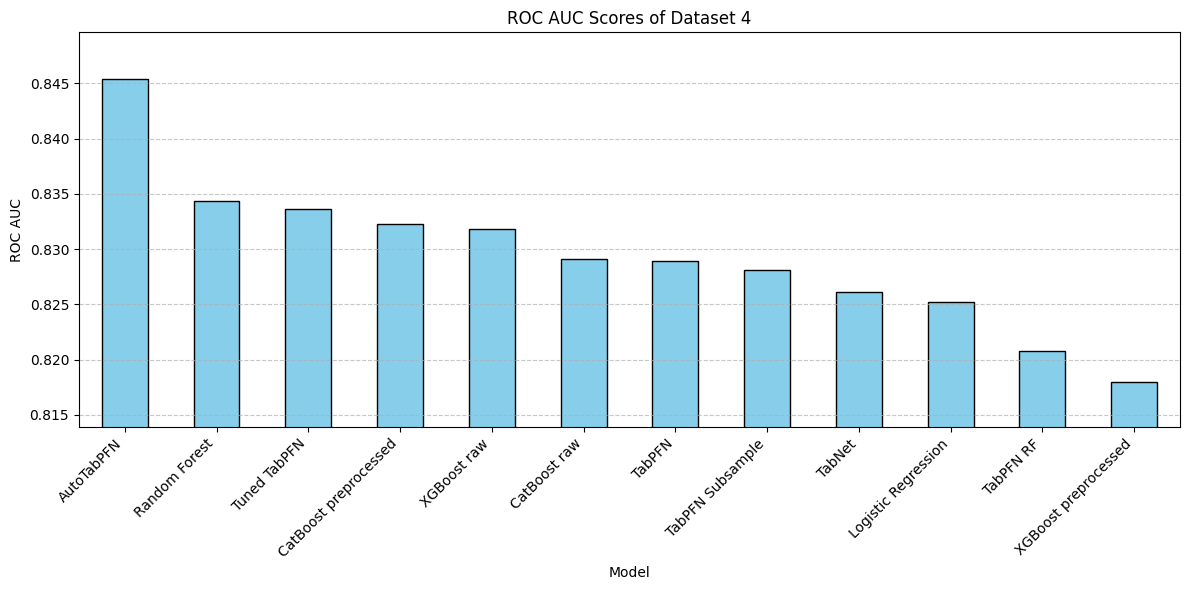

<Axes: title={'center': 'ROC AUC Scores of Dataset 4'}, xlabel='Model', ylabel='ROC AUC'>

In [ ]:
all_metrics_dataset_4 = {
    **metrics_preprocessed_dataset_4,
    **metrics_raw_dataset_4
}

# Plot ROC AUC scores for all models on Dataset 4
plot_roc_auc(all_metrics_dataset_4, dataset_name="Dataset 4")

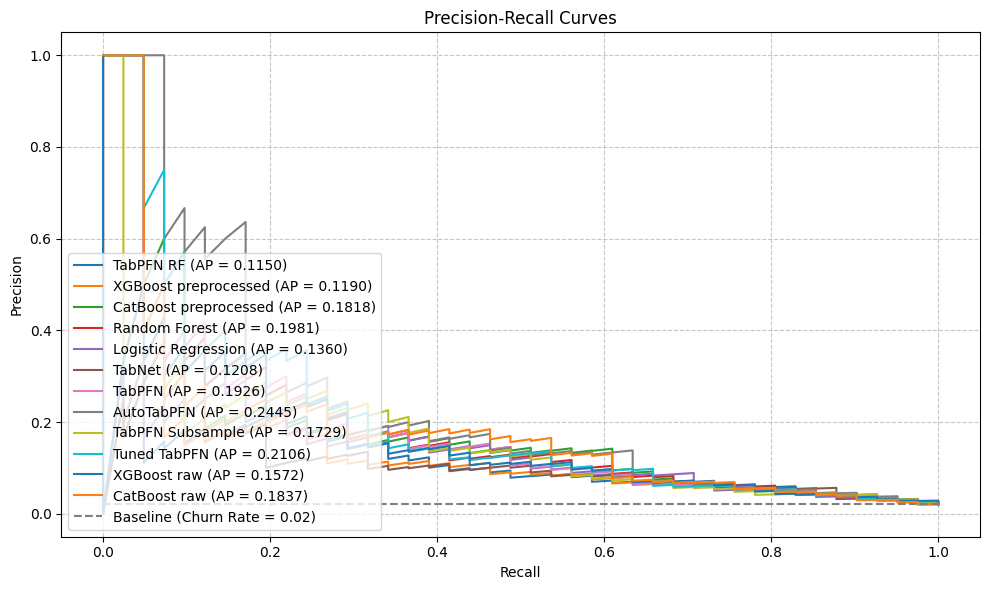

In [ ]:
all_model_probas_dataset_4 = {
    **model_probas_preprocessed_dataset_4,
    **model_probas_raw_dataset_4
}

# Plot precision-recall curves for all models and add churn rate as baseline
plot_precision_recall_curves(all_model_probas_dataset_4, y_test)

###**FINAL RESULTS**###

In [ ]:
# Collect all metrics

metrics_datasets = {
    "Raw Dataset 1": metrics_raw_dataset_1,
    "Raw Dataset 2": metrics_raw_dataset_2,
    "Raw Dataset 3": metrics_raw_dataset_3,
    "Raw Dataset 4": metrics_raw_dataset_4,
    "Preprocessed Dataset 1": metrics_preprocessed_dataset_1,
    "Preprocessed Dataset 2": metrics_preprocessed_dataset_2,
    "Preprocessed Dataset 3": metrics_preprocessed_dataset_3,
    "Preprocessed Dataset 4": metrics_preprocessed_dataset_4,
}

training_time_datasets = {
    "Raw Dataset 1": training_times_raw_dataset_1,
    "Raw Dataset 2": training_times_raw_dataset_2,
    "Raw Dataset 3": training_times_raw_dataset_3,
    "Raw Dataset 4": training_times_raw_dataset_4,
    "Preprocessed Dataset 1": training_times_preprocessed_dataset_1,
    "Preprocessed Dataset 2": training_times_preprocessed_dataset_2,
    "Preprocessed Dataset 3": training_times_preprocessed_dataset_3,
    "Preprocessed Dataset 4": training_times_preprocessed_dataset_4,
}

In [ ]:
def collect_metric(metrics_dict, metric_key):
    """
    Collects a specific metric (e.g., 'ROC AUC', 'PR AUC') from a nested dictionary
    structure and returns a DataFrame with models as rows and datasets as columns.

    Parameters:
    - metrics_dict (dict): Dictionary structured as
        {dataset_name: {model_name: {"ROC AUC": ..., "PR AUC": ...}}}
    - metric_key (str): The metric to extract (e.g., "ROC AUC", "PR AUC")

    Returns:
    - pd.DataFrame: DataFrame with metric values per model and dataset, rounded to 3 decimals
    """
    results = {}
    for dataset_name, model_metrics in metrics_dict.items():
        for model_name, metric_values in model_metrics.items():
            value = metric_values.get(metric_key)
            if model_name not in results:
                results[model_name] = {}
            results[model_name][dataset_name] = value
    return pd.DataFrame(results).T.round(3)

In [ ]:
def collect_times(times_dict):
    """
    Collects training time results from a nested dictionary and returns a DataFrame
    with models as rows and datasets as columns.

    Parameters:
    - times_dict (dict): Dictionary structured as
        {dataset_name: {model_name: training_time}}

    Returns:
    - pd.DataFrame: DataFrame with training times per model and dataset, rounded to 2 decimals
    """
    results = {}
    for dataset_name, model_times in times_dict.items():
        for model_name, time in model_times.items():
            if model_name not in results:
                results[model_name] = {}
            results[model_name][dataset_name] = time
    return pd.DataFrame(results).T.round(2)

In [ ]:
df_roc_auc = collect_metric(metrics_datasets, "ROC AUC")
df_roc_auc["Average ROC AUC"] = df_roc_auc.mean(axis=1)
df_roc_auc = df_roc_auc.sort_values(by="Average ROC AUC", ascending=False)
df_roc_auc

,Raw Dataset 1,Raw Dataset 2,Raw Dataset 3,Raw Dataset 4,Preprocessed Dataset 1,Preprocessed Dataset 2,Preprocessed Dataset 3,Preprocessed Dataset 4,Average ROC AUC
AutoTabPFN,0.865,0.999,0.791,0.845,NaN,NaN,NaN,NaN,0.87500
Tuned TabPFN,0.866,0.999,0.796,0.834,NaN,NaN,NaN,NaN,0.87375
TabPFN RF,NaN,NaN,NaN,NaN,0.851,0.999,0.815,0.821,0.87150
TabPFN,0.865,0.999,0.789,0.829,NaN,NaN,NaN,NaN,0.87050
TabPFN Subsample,0.864,0.999,0.789,0.828,NaN,NaN,NaN,NaN,0.87000
XGBoost raw,0.865,0.990,0.786,0.832,NaN,NaN,NaN,NaN,0.86825
CatBoost preprocessed,NaN,NaN,NaN,NaN,0.864,0.992,0.772,0.832,0.86500
CatBoost raw,0.865,0.989,0.754,0.829,NaN,NaN,NaN,NaN,0.85925
XGBoost preprocessed,NaN,NaN,NaN,NaN,0.863,0.990,0.757,0.818,0.85700
Logistic Regression,NaN,NaN,NaN,NaN,0.862,0.934,0.801,0.825,0.85550


In [ ]:
df_pr_auc = collect_metric(metrics_datasets, "PR AUC")
df_pr_auc["Average PR AUC"] = df_pr_auc.mean(axis=1)
df_pr_auc = df_pr_auc.sort_values(by="Average PR AUC", ascending=False)
df_pr_auc

,Raw Dataset 1,Raw Dataset 2,Raw Dataset 3,Raw Dataset 4,Preprocessed Dataset 1,Preprocessed Dataset 2,Preprocessed Dataset 3,Preprocessed Dataset 4,Average PR AUC
AutoTabPFN,0.699,0.994,0.522,0.245,NaN,NaN,NaN,NaN,0.61500
TabPFN,0.700,0.993,0.474,0.193,NaN,NaN,NaN,NaN,0.59000
Tuned TabPFN,0.700,0.992,0.447,0.211,NaN,NaN,NaN,NaN,0.58750
TabPFN Subsample,0.696,0.993,0.474,0.173,NaN,NaN,NaN,NaN,0.58400
CatBoost preprocessed,NaN,NaN,NaN,NaN,0.698,0.960,0.475,0.182,0.57875
TabPFN RF,NaN,NaN,NaN,NaN,0.682,0.995,0.517,0.115,0.57725
CatBoost raw,0.699,0.946,0.408,0.184,NaN,NaN,NaN,NaN,0.55925
XGBoost raw,0.702,0.951,0.414,0.157,NaN,NaN,NaN,NaN,0.55600
Random Forest,NaN,NaN,NaN,NaN,0.699,0.942,0.377,0.198,0.55400
XGBoost preprocessed,NaN,NaN,NaN,NaN,0.695,0.944,0.380,0.119,0.53450


In [ ]:
df_time = collect_times(training_time_datasets)
df_time["Average Time (s)"] = df_time.mean(axis=1)
df_time = df_time.sort_values(by="Average Time (s)")
df_time

,Raw Dataset 1,Raw Dataset 2,Raw Dataset 3,Raw Dataset 4,Preprocessed Dataset 1,Preprocessed Dataset 2,Preprocessed Dataset 3,Preprocessed Dataset 4,Average Time (s)
TabPFN Subsample,0.23,0.15,0.18,0.18,NaN,NaN,NaN,NaN,0.1850
TabPFN,0.30,0.18,0.20,0.37,NaN,NaN,NaN,NaN,0.2625
TabPFN RF,NaN,NaN,NaN,NaN,0.75,0.45,0.34,0.97,0.6275
XGBoost preprocessed,NaN,NaN,NaN,NaN,1.63,1.84,3.27,3.38,2.5300
XGBoost raw,4.51,3.11,3.49,4.14,NaN,NaN,NaN,NaN,3.8125
Random Forest,NaN,NaN,NaN,NaN,5.29,3.62,3.05,5.30,4.3150
Logistic Regression,NaN,NaN,NaN,NaN,7.06,2.97,3.51,24.78,9.5800
CatBoost preprocessed,NaN,NaN,NaN,NaN,10.77,11.41,12.89,10.58,11.4125
CatBoost raw,28.38,14.85,33.61,28.94,NaN,NaN,NaN,NaN,26.4450
Tuned TabPFN,42.93,58.01,23.27,185.90,NaN,NaN,NaN,NaN,77.5275
